# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [ ]:
import copy
import math
from typing import Callable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import time
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Problem formulation

Let's solve the following problem (in Frobenius norm):
$$ \min\_{U \in \R^{m\times r}, V \in \R^{r\times n}} \|W \circ (X - UV)\|^2_F$$

where:

- $X$ - target matrix ($m\times n$)
- $W$ - binary mask
- $r$ - rank of factorization

In order to use gradient methods, we need to derive it with respect to each parameter ($U$ and $V$) (check this [link](https://hushtheblock.github.io/2020/08/06/Derivative-of-a-function/)):

$$ \cfrac{\partial \|W \circ (X - UV)\|^2_F}{\partial U} = -2 (W \circ X) V^T + 2 (W \circ (UV)) V^T$$

$$ \cfrac{\partial \|W \circ (X - UV)\|^2_F}{\partial V} = -2 U^T (W \circ X) + 2 U^T (W \circ (UV)) $$

As a modified problem, we decided just to add some regularization. This brings us to the following forms:

$$ \min\_{U \in \R^{m\times r}, V \in \R^{r\times n}} \|W \circ (X - UV)\|^2_F + \lambda\|U\|^2_F + \lambda\|V\|^2_F$$

$$ \cfrac{\partial (\|W \circ (X - UV)\|^2_F + \lambda\|U\|^2_F + \lambda\|V\|^2_F)}{\partial U} = -2 (W \circ X) V^T + 2 (W \circ (UV)) V^T + 2\lambda U$$

$$ \cfrac{\partial (\|W \circ (X - UV)\|^2_F + \lambda\|U\|^2_F + \lambda\|V\|^2_F)}{\partial V} = -2 U^T (W \circ X) + 2 U^T (W \circ (UV)) + 2\lambda V$$

where $\lambda$ - regularization parameter.

The main idea - using different optimizers, lr strategies and hyperparameters (iterations, rank, regularization, init strategies) find the best approximation of target matrix $X$ on test data.

Note: Since we are working with matrices, then gradients are also matrices, thus some lr strategies and optimizers require dot product between descent direction and gradient - which are matrices. Therefore, we are using Frobenius inner product, which is defined as:
$$ \langle A, B \rangle_F = Tr (A^T B) $$


## Utilities


In [3]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(
    possible_params_dict: dict[str, list]
) -> list[tuple[dict, str]]:
    if len(possible_params_dict) == 0:
        return [({}, "")]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            ({first_item[0]: first_item[1], **k}, name)
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    if (
        len(first_item[1]) > 0
        and isinstance(first_item[1][0], tuple)
        and isinstance(first_item[1][0][0], str)
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x_name}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x_name, x in first_item[1]
        ]

    if (
        len(first_item[1]) > 0 and str(first_item[1][0]) != "<"  # has ___str__
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x!s}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x in first_item[1]
        ]

    return [
        (
            {first_item[0]: x, **k},
            f"{first_item[0]}=[{x}]{', ' + name if len(name) > 0 else ''}",
        )
        for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [4]:
def rmse_score(
    initial_matrix: torch.Tensor, predicted_matrix: torch.Tensor, test_mask: torch.Tensor
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return torch.sqrt(differences.mean()).item()


def predict_matrix(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    return torch.clip(u @ v, 1, 5)

In [5]:
def choose_best(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    solver: Callable,
    possible_params: dict,
) -> tuple[torch.Tensor, float, int, float, str, dict]:
    matrix = matrix.to(DEVICE)
    mask = mask.to(DEVICE)
    test_mask = test_mask.to(DEVICE)

    best_loss = 1e3
    best_time = 1e3
    best_solution = torch.zeros(1)
    best_iter = 0
    best_name = ""

    log_dicts = {}

    for params, name in get_params_combinations_dict(possible_params):
        log_dict = solver(matrix, mask, test_mask, **params)
        log_dicts[name] = log_dict

        loss = log_dict["best_rmse_test"]
        total_time = log_dict["best_time"]

        if loss < best_loss or (loss == best_loss and total_time < best_time):
            best_loss = loss
            best_time = total_time
            best_iter = log_dict["best_k"]
            best_name = name
            best_u = log_dict["best_u"].to(DEVICE)
            best_v = log_dict["best_v"].to(DEVICE)

    best_solution = matrix + (~mask) * predict_matrix(best_u, best_v)
    return best_solution, best_loss, best_iter, best_time, best_name, log_dicts

In [ ]:
def plot_log_dicts(
    log_dicts: dict,
    title: str,
    row_plots: int = 2,
    plot_width: float = 8,
    plot_height: float = 4,
):
    num_plots = 8
    row_plots = min(row_plots, num_plots)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )
    axs_list = list(axs.flat)

    for ax in axs_list:
        ax.grid()

    axs_list[0].set(xlabel="Iteration", ylabel="RMSE, log")
    axs_list[1].set(xlabel="Time, seconds", ylabel="RMSE, log")
    axs_list[2].set(xlabel="Iteration", ylabel="Objective, log")
    axs_list[3].set(xlabel="Time, seconds", ylabel="Objective, log")
    axs_list[4].set(xlabel="Iteration", ylabel="RMSE on test, log")
    axs_list[5].set(xlabel="Time, seconds", ylabel="RMSE on test, log")
    axs_list[6].set(xlabel="Iteration", ylabel="Objective on test, log")
    axs_list[7].set(xlabel="Time, seconds", ylabel="Objective on test, log")

    for i, ax in enumerate(axs_list):
        if i < 4:
            ax.set_title("Results on train data")
            continue
        ax.set_title("Results on test data")

    for ax in axs_list:
        ax.set_yscale("log")

    for name, log_dict in log_dicts.items():
        for i, label in [(0, "iteration"), (1, "time")]:
            axs_list[0 + i].plot(log_dict[label], log_dict["rmse"], label=name)
            axs_list[2 + i].plot(log_dict[label], log_dict["objective"], label=name)
            axs_list[4 + i].plot(log_dict[label], log_dict["rmse_test"], label=name)
            axs_list[6 + i].plot(log_dict[label], log_dict["objective_test"], label=name)

    fig.suptitle(title, fontsize=14)

    lines_labels = [axs_list[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    max_in_row = 3
    fig.legend(
        lines,
        labels,
        loc="outside lower center",
        ncol=min(max_in_row, len(log_dicts)),
        bbox_to_anchor=(0.5, -0.05 * math.ceil(len(log_dicts) / (2.5 * max_in_row))),
    )

    plt.tight_layout(w_pad=5)
    plt.show()


def plot_log_dicts_test(
    log_dicts: dict,
    title: str,
    need_legend: bool = True,
):
    fig, axs = plt.subplots(figsize=(4, 3))

    axs.set(xlabel="Iteration", ylabel="RMSE on test, log")
    axs.set_yscale("log")

    for name, log_dict in log_dicts.items():
        axs.plot(log_dict["iteration"], log_dict["rmse_test"], label=name)

    lines_labels = [axs.get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    if need_legend:
        fig.legend(
            lines,
            labels,
            borderaxespad=0,
            bbox_to_anchor=(1.9, 1),
        )

    plt.tight_layout(w_pad=5)
    plt.show()


def plot_double_log_dicts_test(
    log_dicts: dict,
    title: str,
    need_legend: bool = True,
):
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))

    axs[0].set(xlabel="Iteration", ylabel="RMSE on train, log")
    axs[0].set_yscale("log")
    axs[1].set(xlabel="Iteration", ylabel="RMSE on test, log")
    axs[1].set_yscale("log")

    for name, log_dict in log_dicts.items():
        axs[0].plot(log_dict["iteration"], log_dict["rmse"], label=name)
        axs[1].plot(log_dict["iteration"], log_dict["rmse_test"], label=name)

    lines_labels = [axs[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    if need_legend:
        fig.legend(
            lines,
            labels,
            borderaxespad=0,
            bbox_to_anchor=(1.3, 1),
        )

    plt.tight_layout(w_pad=5)
    plt.show()

In [7]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return torch.tensor(train_matrix.reshape(matrix_shape)).float().to(
        DEVICE
    ), torch.tensor(train_mask.reshape(matrix_shape)).bool().to(DEVICE), torch.tensor(
        test_mask.reshape(matrix_shape)
    ).bool().to(DEVICE), torch.tensor(matrix).float().to(DEVICE), torch.tensor(
        mask
    ).bool().to(DEVICE)

## Data loading


### Toy data


In [8]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)

toy_mask_full = toy_matrix_full != 0

In [9]:
toy_mask_full

array([[ True,  True,  True, False, False],
       [False,  True, False,  True,  True],
       [ True, False,  True, False,  True],
       [False,  True, False,  True,  True],
       [False, False, False, False,  True],
       [ True,  True,  True,  True, False]])

In [10]:
(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    toy_matrix_full,
    toy_mask_full,
) = train_test_split_matrix(toy_matrix_full, toy_mask_full, test_percent=0.2)

### Real data


In [11]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask


real_matrix_full, real_mask_full = load_real_data()

In [12]:
(
    real_matrix,
    real_mask,
    real_test_mask,
    real_matrix_full,
    real_mask_full,
) = train_test_split_matrix(real_matrix_full, real_mask_full, test_percent=0.2)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 160033


## Test real data


In [13]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> torch.Tensor:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0].astype(np.float64) - 1
    columns_indices = x[:, 1].astype(np.float64) - 1
    return (
        torch.tensor(rows_indices * real_matrix_shape[1] + columns_indices)
        .int()
        .to(DEVICE)
    )


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

tensor([     593,     3104,     1544,  ..., 23868889, 23868137, 23868149],
       device='cuda:0', dtype=torch.int32)

In [14]:
def save_solution(
    matrix: torch.Tensor,
    test_flatten_indices: torch.Tensor = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(
        matrix.flatten()[test_flatten_indices].cpu().numpy(), decimals=decimals
    )
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Boosters


### LR strategies


In [15]:
class LearningRateScheduler:
    @staticmethod
    def _vector_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return x.dot(y)

    @staticmethod
    def _matrix_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.trace(x.T @ y)

    def __init__(self, assume_vectors: bool = False) -> None:
        self.set_assume_vectors(assume_vectors)
        self.reset()

    def reset(self) -> None:
        pass

    def set_assume_vectors(self, assume_vectors: bool):
        self.assume_vectors = assume_vectors
        self.dot = (
            LearningRateScheduler._vector_dot
            if self.assume_vectors
            else LearningRateScheduler._matrix_dot
        )

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        raise NotImplementedError


class Normal(LearningRateScheduler):
    def __init__(
        self,
        lr: Callable[[int], float] | float = 1e-3,
        name: str = "",
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.name = name
        self.lr = lr
        self.lr_func: Callable[[int], float] = (
            (lambda _: lr) if isinstance(lr, float) else lr
        )  # type: ignore

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        return self.lr_func(k)

    def __str__(self) -> str:
        return (
            self.name
            if self.name
            else (str(self.lr) if isinstance(self.lr, float) else "normal")
        )


class Estimate1OverL(LearningRateScheduler):
    def __init__(
        self,
        beta: float = 0.5,
        max_iters: int = 100,
        eps: float = 1e-7,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.beta = beta
        self.max_iters = max_iters
        self.eps = eps

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = 1
        d_norm = torch.norm(direction)

        for _ in range(self.max_iters):
            x_next = x + alpha * direction
            if torch.norm(grad - grad_f(x_next)) > torch.norm(d_norm):
                alpha *= self.beta
                if alpha < 1e-10:
                    return alpha

            else:
                return alpha

        return alpha

    def __str__(self) -> str:
        return "1/L"


class AdaptiveStep(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1e-6,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step

    def reset(self) -> None:
        self.theta = np.inf
        self.prev_step = None

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        if self.prev_step is None:
            step = self.start_step
            self.theta = np.inf
            self.prev_step = step
            return step

        step = self.prev_step
        if torch.norm(prev_grad - grad) < 1e-5:
            min_value = np.sqrt(1 + self.theta) * step
        else:
            min_value = min(
                np.sqrt(1 + self.theta) * step,
                float(
                    (torch.norm(x - prev_x) / (2 * torch.norm(prev_grad - grad)))
                    .cpu()
                    .numpy(),
                ),
            )
        if min_value == np.inf:
            min_value = 0.001

        self.theta = min_value / step
        step = min_value
        self.prev_step = step

        return step

    def __str__(self) -> str:
        return "adaptive"


class Armijo(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-6,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step

        d_g = self.dot(grad, direction).item()
        f_x = f(x)

        i = 0
        while f(x + alpha * direction) > f_x + self.c1 * alpha * d_g:
            i += 1

            if i == self.max_iters:
                return alpha

            if alpha < 1e-7:
                return alpha

            alpha = alpha * self.beta

        return alpha

    def __str__(self) -> str:
        return "armijo"


class StrongWolfe(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-4,
        c2: float = 0.9,
        beta: float = 0.5,
        max_iters: int = 50,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step
        d_g = self.dot(grad, direction)
        abs_d_g = torch.abs(d_g)
        f_x = f(x)

        for _ in range(self.max_iters):
            if alpha < 1e-7:
                return alpha

            x_new = x + alpha * direction

            armijo_condition = f(x_new) > f_x + self.c1 * alpha * d_g
            curvature_condition = (
                torch.abs(self.dot(grad_f(x_new), direction)) > self.c2 * abs_d_g
            )
            if armijo_condition or curvature_condition:
                alpha *= self.beta
                continue
            return alpha
        return alpha

    def __str__(self) -> str:
        return "strong_wolfe"


class BisectionWolfe(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-5,
        c2: float = 0.9,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.max_iters = max_iters

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step
        lb = 0
        ub = np.inf
        d_g = self.dot(grad, direction)
        f_x = f(x)

        for _ in range(self.max_iters):
            if alpha < 1e-16:
                return alpha
            if f(x + alpha * direction) > f_x + self.c1 * alpha * d_g:
                ub = alpha
                alpha = 0.5 * (lb + ub)
            elif self.dot(grad_f(x + alpha * direction), direction) < self.c2 * d_g:
                lb = alpha
                alpha = 2 * lb if np.isinf(ub) else 0.5 * (lb + ub)
            else:
                return alpha
        return alpha

    def __str__(self) -> str:
        return "bisection_wolfe"

### Optimizers


In [16]:
class Optimizer:
    def __init__(self, lr_scheduler: LearningRateScheduler) -> None:
        self.lr_scheduler = lr_scheduler
        self.reset()

    def reset(self) -> None:
        self.prev_grad = torch.zeros(1)
        self.prev_x = torch.zeros(1)
        self.lr_scheduler.reset()

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        beta: float = 0.0,
        nesterov: bool = False,
    ) -> None:
        super().__init__(lr_scheduler)
        self.beta = beta
        self.nesterov = nesterov

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.beta > 0:
            self.h = grad.clone() if k == 1 else (self.beta * self.h_prev + grad)

            if self.nesterov:
                direction = -(grad + self.beta * self.h)
            else:
                direction = -self.h
            self.h_prev = self.h.clone()
        else:
            direction = -grad.clone()

        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        name = "GD"
        if self.beta:
            name = f"{'Nesterov' if self.nesterov else 'HB'} b={self.beta}"
        return f"{name} lr={self.lr_scheduler!s}"


class AdaGrad(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        lr_decay: float = 0,
    ) -> None:
        super().__init__(lr_scheduler)

        self.lr_decay = lr_decay
        self.eps = eps

    def reset(self) -> None:
        super().reset()
        self.state_sum = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.state_sum is None:
            self.state_sum = torch.zeros_like(grad)

        self.state_sum += grad**2

        direction = -grad / torch.sqrt(self.state_sum + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )
        gamma = lr / (1 + k * self.lr_decay)

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + gamma * direction

    def __str__(self) -> str:
        return f"AdaGrad lr={self.lr_scheduler!s} lr_decay={self.lr_decay}"


class RMSprop(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        alpha=0.99,
    ) -> None:
        super().__init__(lr_scheduler)

        self.alpha = alpha
        self.eps = eps

    def reset(self) -> None:
        super().reset()
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.exp_avg_sq is None:
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        direction = -grad / torch.sqrt(self.exp_avg_sq + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"RMSprop lr={self.lr_scheduler!s} a={self.alpha}"


class Adam(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        betas: tuple[float, float] = (0.9, 0.999),
        eps=1e-10,
        weight_decay: float = 1e-2,
    ) -> None:
        super().__init__(lr_scheduler)

        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def reset(self) -> None:
        super().reset()
        self.exp_avg = None
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        beta1, beta2 = self.betas
        if self.exp_avg is None or self.exp_avg_sq is None:
            self.exp_avg = torch.zeros_like(x)
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        self.exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**k
        bias_correction2 = 1 - beta2**k

        denom = self.exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        direction = -(
            torch.div(self.exp_avg, bias_correction1).div_(denom) + self.weight_decay * x
        )
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"Adam lr={self.lr_scheduler!s} b1={self.betas[0]} b2={self.betas[0]} w={self.weight_decay}"

In [17]:
class BFGS(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler = StrongWolfe(assume_vectors=True),
    ) -> None:
        super().__init__(lr_scheduler)

    def reset(self) -> None:
        super().reset()
        self.h = None
        self.identity = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        if not self.lr_scheduler.assume_vectors:
            raise BaseException("Vectors required")

        grad = grad_f(x)

        if self.h is None:
            self.h = torch.eye(x.shape[0]).to(x.device)
            self.identity = self.h.clone()

        direction = -(self.h @ grad)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        if lr:
            x_new = x + lr * direction

            # Update H
            s = x_new - x
            y = grad_f(x_new) - grad

            r = 1 / (torch.dot(y, s) + 1e-10)
            ss = torch.outer(s, s)

            self.h = (
                self.h
                + r**2 * (torch.dot(y, s) + torch.dot(y, self.h @ y)) * ss
                - r * (self.h @ torch.outer(y, s) + torch.outer(s, y) @ self.h)
            )
        else:
            x_new = x - 1e-5 * grad

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x_new

    def __str__(self) -> str:
        return f"BFGS lr={self.lr_scheduler!s}"

### Other


In [18]:
class Logger:
    def __init__(
        self,
        matrix: torch.Tensor,
        mask: torch.Tensor,
        test_mask: torch.Tensor,
        f: Callable,
        f_params: dict = {},
        verbose: bool = True,
    ) -> None:
        self.matrix = matrix
        self.mask = mask
        self.test_mask = test_mask
        self.f = f
        self.f_params = f_params

        self.start_time = time.time()
        self._log_dict = {
            "objective": [],
            "objective_test": [],
            "rmse": [],
            "rmse_test": [],
            "time": [],
            "iteration": [],
            # Best part
            "best_rmse_test": 1e10,
            "best_k": 0,
            "best_time": 0,
            "best_u": torch.ones(1),
            "best_v": torch.ones(1),
        }
        self.verbose = verbose

    def log(
        self, u: torch.Tensor, v: torch.Tensor, k: int, loop: Optional[tqdm.tqdm] = None
    ):
        torch.cuda.current_stream().synchronize()

        objective = self.f(self.matrix, self.mask, u, v, **self.f_params)
        objective_test = self.f(self.matrix, self.test_mask, u, v, **self.f_params)

        rmse_sc = rmse_score(self.matrix, predict_matrix(u, v), self.mask)
        rmse_sc_test = rmse_score(self.matrix, predict_matrix(u, v), self.test_mask)
        if k == 0:
            self.start_time = time.time()
            end_time = 0
        else:
            end_time = time.time() - self.start_time
        self._log_dict["objective"].append(objective)
        self._log_dict["objective_test"].append(objective_test)
        self._log_dict["rmse"].append(rmse_sc)
        self._log_dict["rmse_test"].append(rmse_sc_test)
        self._log_dict["time"].append(end_time)
        self._log_dict["iteration"].append(k)
        if self.verbose and loop:
            loop.set_postfix(
                {
                    "Objective": objective,
                    "RMSE": rmse_sc,
                    "Objective[test]": objective_test,
                    "RMSE[test]": rmse_sc_test,
                }
            )

        # Update best
        if rmse_sc_test < self._log_dict["best_rmse_test"]:
            self._log_dict["best_rmse_test"] = rmse_sc_test
            self._log_dict["best_k"] = k
            self._log_dict["best_time"] = end_time
            self._log_dict["best_u"] = u.clone()
            self._log_dict["best_v"] = v.clone()

    @property
    def log_dict(self) -> dict:
        return self._log_dict

## Gradient Descent


### Train


In [19]:
def init_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    rank: int,
    strategy: Literal["random", "svd"],
    device: torch.device,
) -> tuple[torch.Tensor, torch.Tensor]:
    m, n = matrix.shape
    new_matrix = (mask * matrix).cpu().numpy()

    if strategy == "random":
        return torch.rand(m, rank).to(device), torch.rand(rank, n).to(device)

    if strategy == "svd":
        new_matrix = SimpleImputer(
            strategy="mean", missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(  # type: ignore
        new_matrix, n_iter=25, n_components=rank
    )

    return torch.tensor(u).float().to(device), torch.tensor(vt).float().to(device)


def objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    regularization: float = 0.0,
) -> float:
    return (
        torch.norm(mask * torch.pow((matrix - (u @ v)), 2), p="fro")
        + regularization * (torch.norm(u, p="fro") ** 2 + torch.norm(v, p="fro") ** 2)
    ).item()


def nabla_objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.Tensor:
    if for_v:
        return (
            -2 * u.T @ (mask * matrix)
            + 2 * u.T @ (mask * (u @ v))
            + regularization * 2 * v
        )

    return (
        -2 * (mask * matrix) @ v.T + 2 * (mask * (u @ v)) @ v.T + regularization * 2 * u
    )


def pure_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Optimizer,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    verbose: bool = True,
    seed: int = 420,
    device: torch.device = DEVICE,
) -> dict:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    matrix = matrix.to(device)
    mask = mask.to(device)
    test_mask = test_mask.to(device)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy, device=device)
    optimizer.reset()
    u_optim = optimizer
    v_optim = copy.deepcopy(optimizer)

    # Initial log
    logger = Logger(
        matrix,
        mask,
        test_mask,
        objective_gd,
        f_params={"regularization": 0},
        verbose=verbose,
    )
    logger.log(u, v, 0)

    with tqdm.tqdm(range(1, iterations + 1), disable=not verbose) as loop:
        for k in loop:
            # Optimize
            u = u_optim.step(
                u,
                lambda x: objective_gd(matrix, mask, x, v, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, x, v, regularization=regularization
                ),
                k,
            )

            v = v_optim.step(
                v,
                lambda x: objective_gd(matrix, mask, u, x, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, u, x, for_v=True, regularization=regularization
                ),
                k,
            )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            logger.log(u, v, k, loop=loop)

        return logger.log_dict

100%|██████████| 10/10 [00:00<00:00, 185.81it/s, Objective=1.67, RMSE=0.514, Objective[test]=2.05, RMSE[test]=0.893]


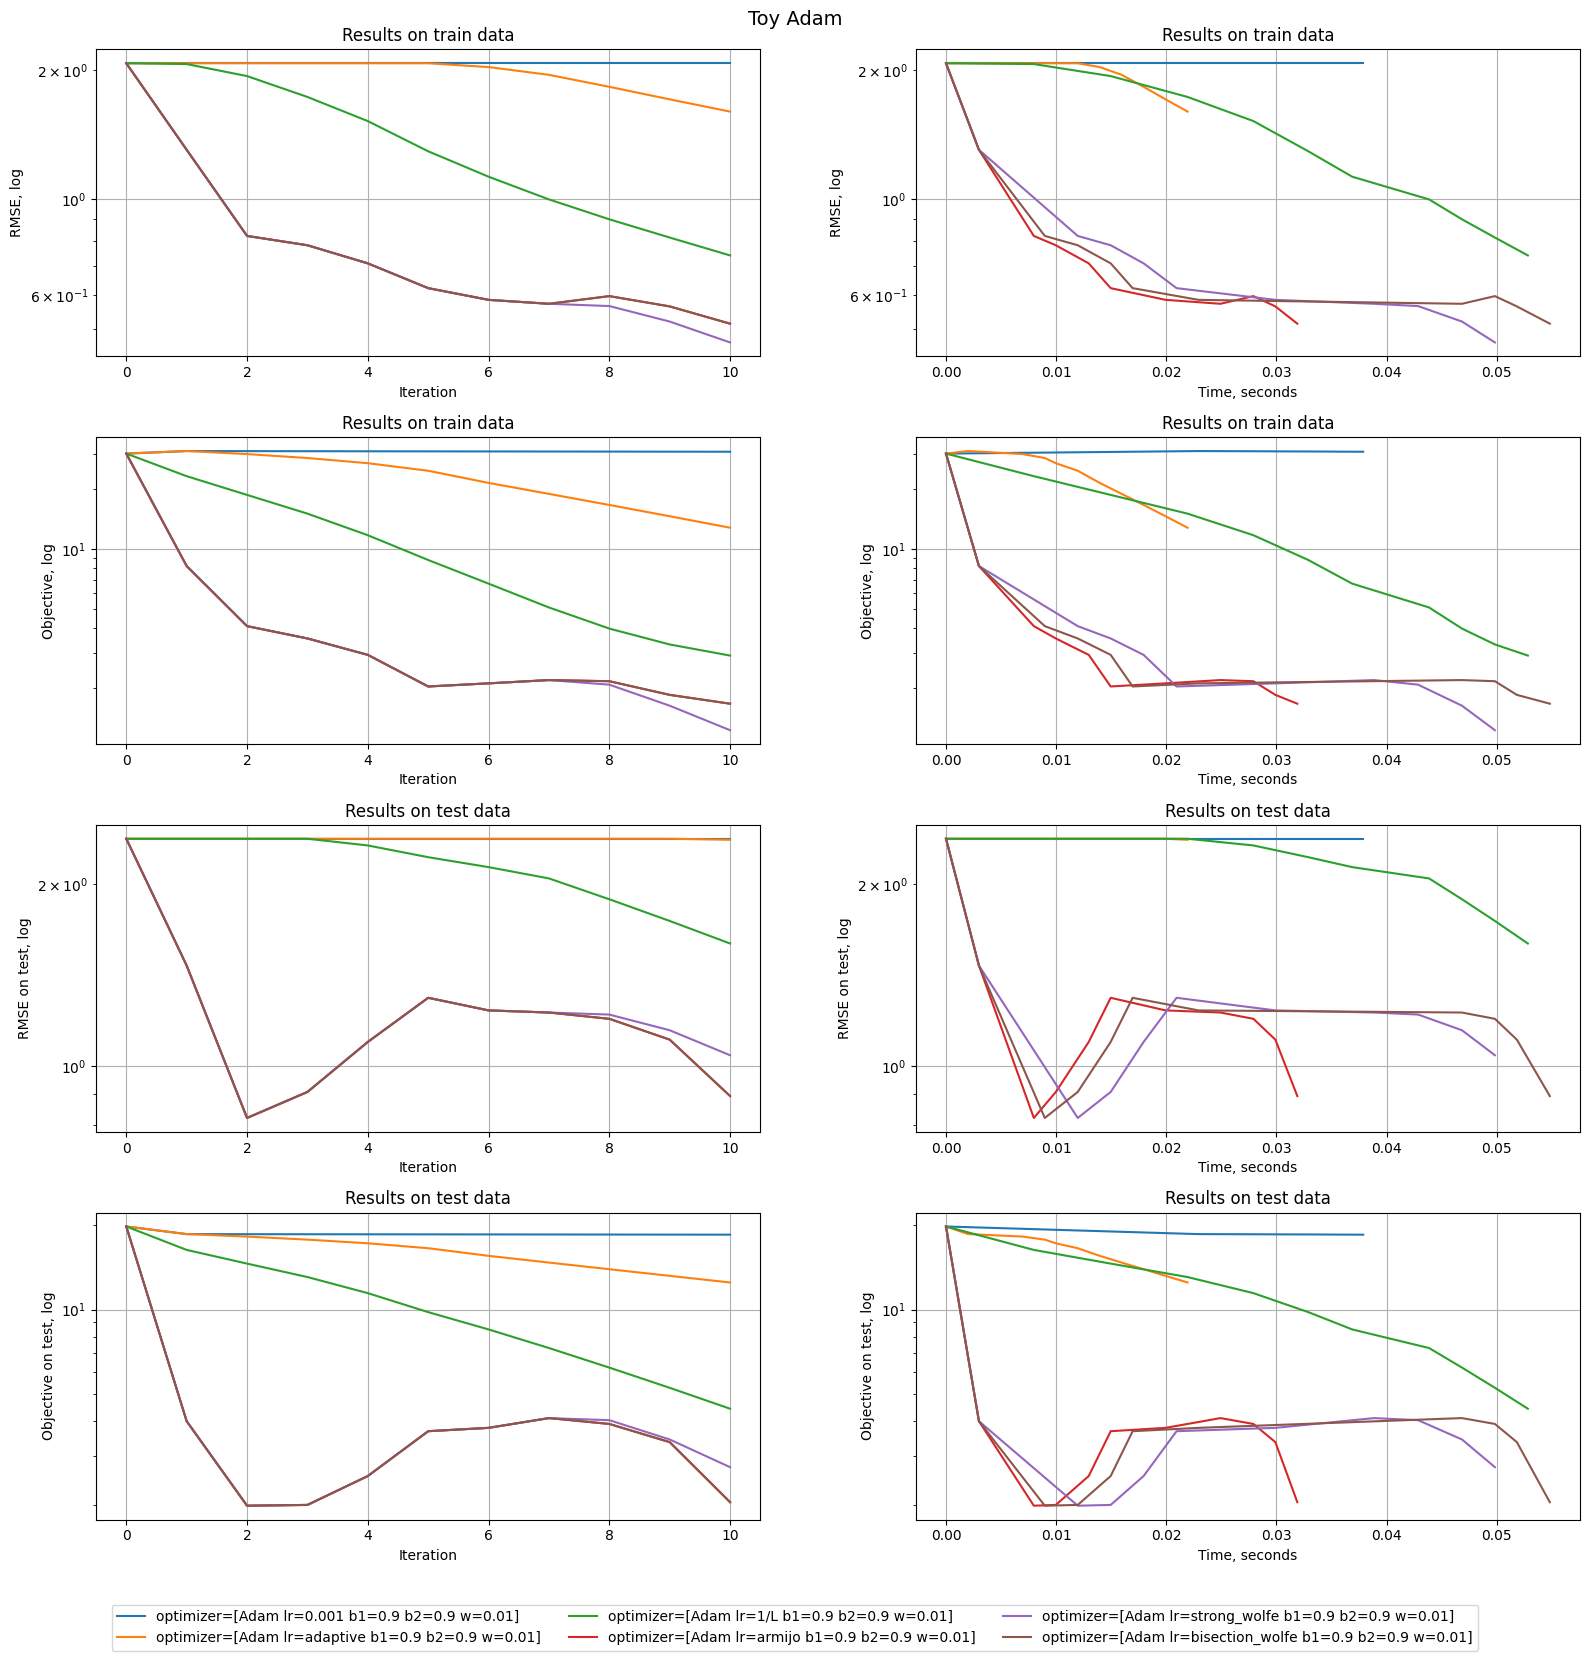

(tensor([[2.0000, 3.0000, 2.0000, 2.1232, 2.4226],
         [3.0547, 2.0000, 3.3747, 4.0000, 5.8284],
         [3.0000, 1.3454, 3.0000, 1.6551, 4.0000],
         [3.1500, 3.0000, 3.4799, 4.0000, 5.9166],
         [1.8464, 1.0000, 1.9120, 1.0000, 2.0000],
         [1.0000, 6.5901, 3.0000, 4.0000, 2.5776]], device='cuda:0'),
 0.8214219212532043,
 2,
 0.007972955703735352,
 'optimizer=[Adam lr=armijo b1=0.9 b2=0.9 w=0.01]')

In [20]:
gd_toy_res = choose_best(
    toy_matrix_full,
    toy_mask,
    toy_test_mask,
    pure_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "sgd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                Adam(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-3),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "clip": True,
        "verbose": True,
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy Adam")

gd_toy_res[:-1]

### Experiments


#### Gradient Descent


100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Objective=1.55e+3, RMSE=0.97, Objective[test]=821, RMSE[test]=0.998]   


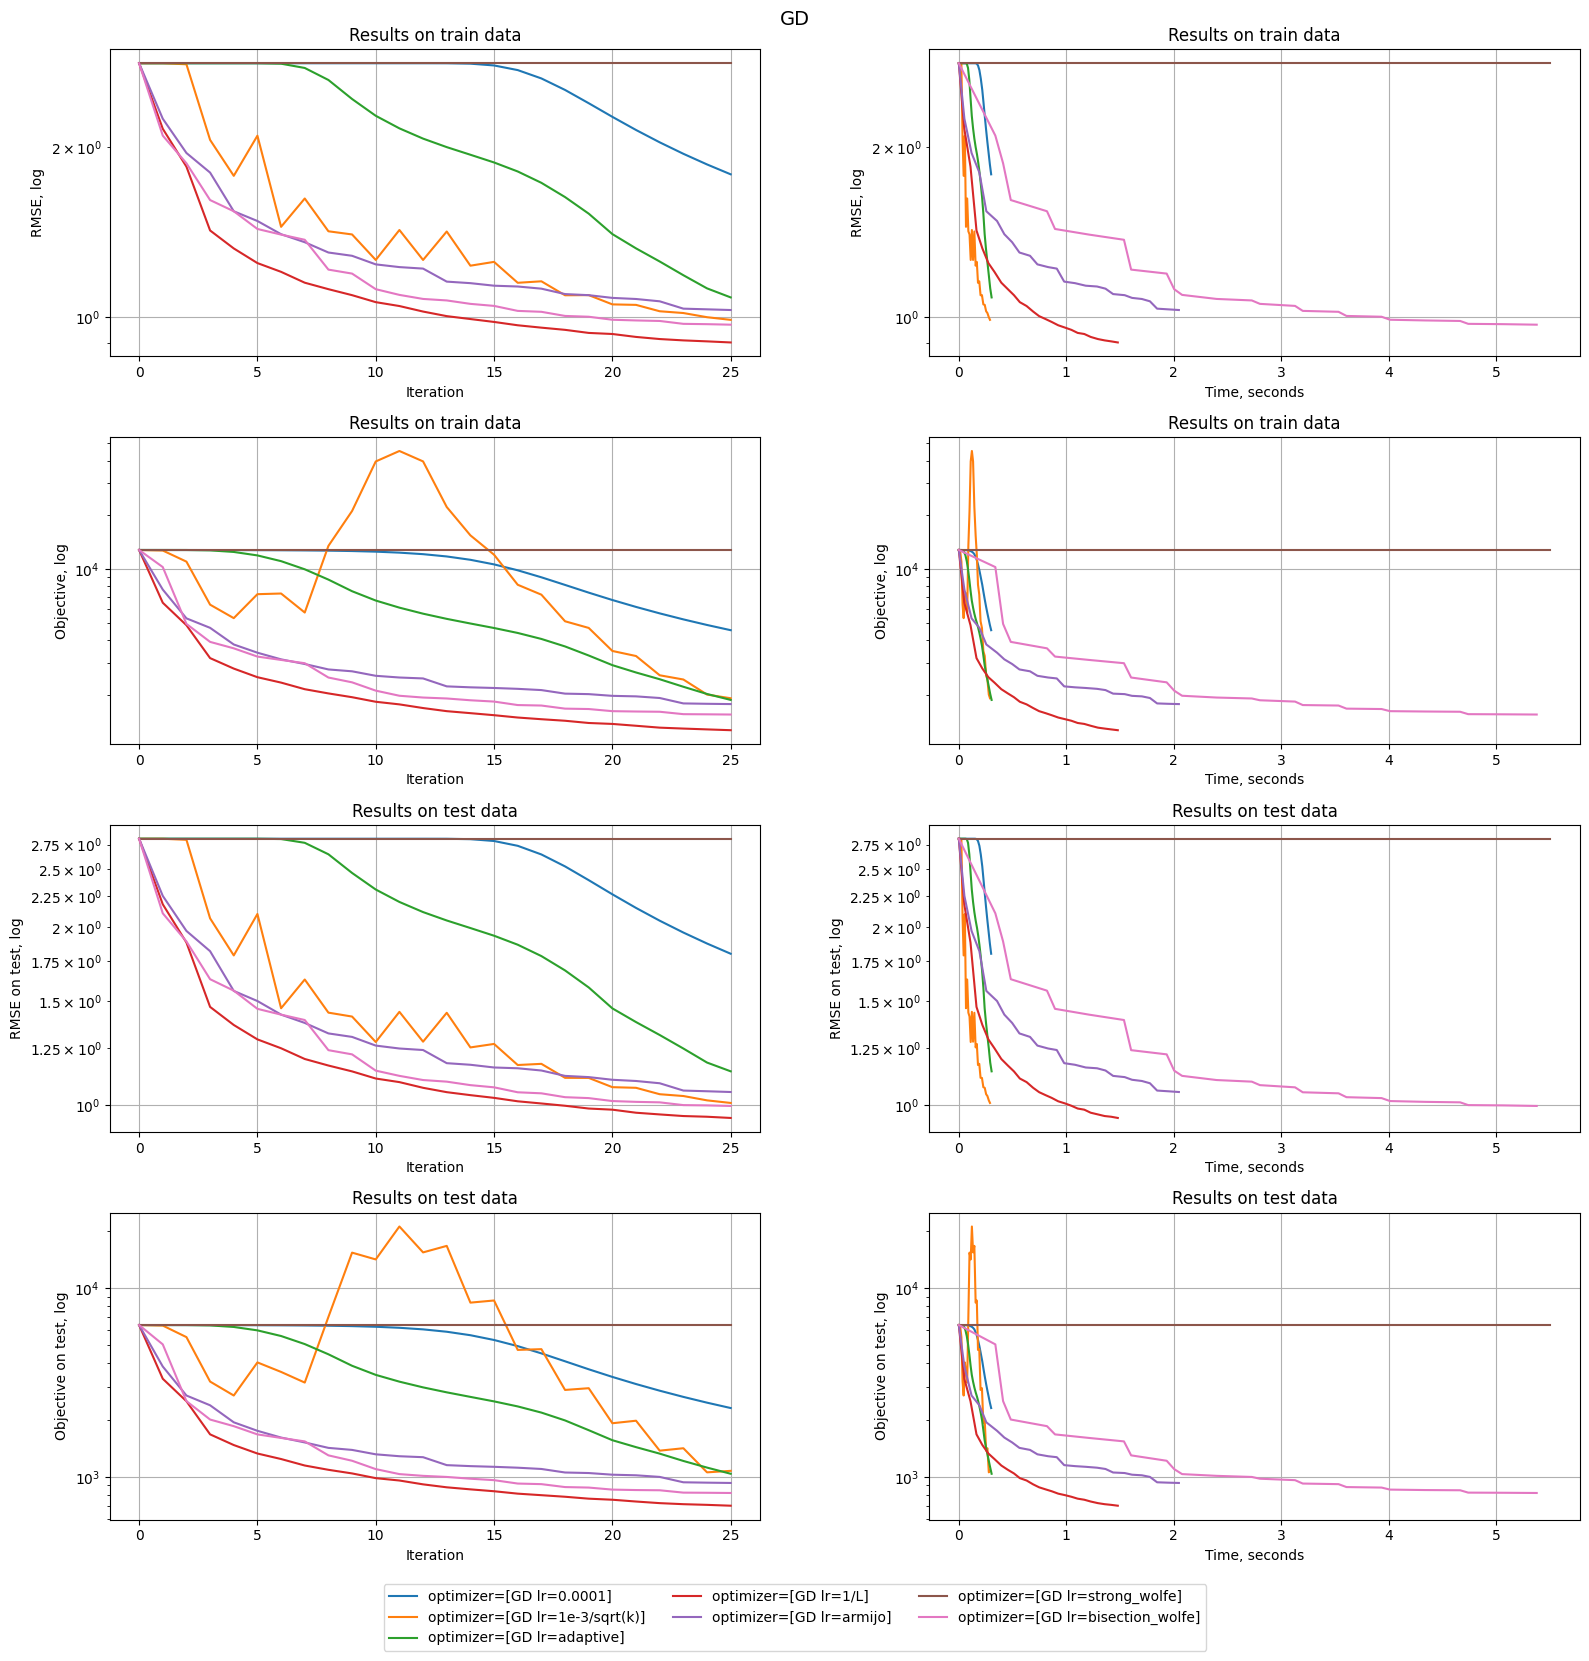

(tensor([[5.0000, 3.2106, 2.7248,  ..., 1.7788, 1.4131, 3.1168],
         [3.8489, 2.8403, 2.6986,  ..., 2.1458, 1.6330, 3.7232],
         [4.0596, 2.9360, 2.8211,  ..., 1.9367, 1.4098, 3.5030],
         ...,
         [3.0628, 1.9934, 1.8784,  ..., 1.4895, 1.1821, 2.5306],
         [4.1260, 2.7559, 2.3069,  ..., 2.0787, 1.7225, 3.1345],
         [3.0000, 1.7659, 1.5726,  ..., 2.5655, 2.3559, 3.5109]],
        device='cuda:0'),
 0.9523747563362122,
 25,
 1.479910135269165,
 'optimizer=[GD lr=1/L]')

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-4),
                    Normal(lambda k: 1e-3 / np.sqrt(k), "1e-3/sqrt(k)"),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

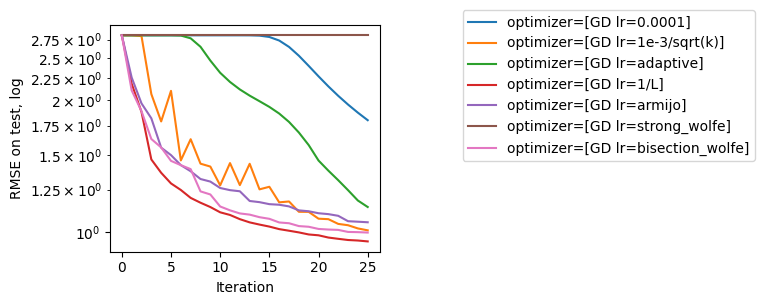

In [114]:
plot_log_dicts_test(gd_res[-1], "GD")

Let's choose 1/L for Gradient descent for future comparison


#### Heavy ball


100%|██████████| 25/25 [00:04<00:00,  5.49it/s, Objective=2.58e+3, RMSE=1.26, Objective[test]=1.34e+3, RMSE[test]=1.28]


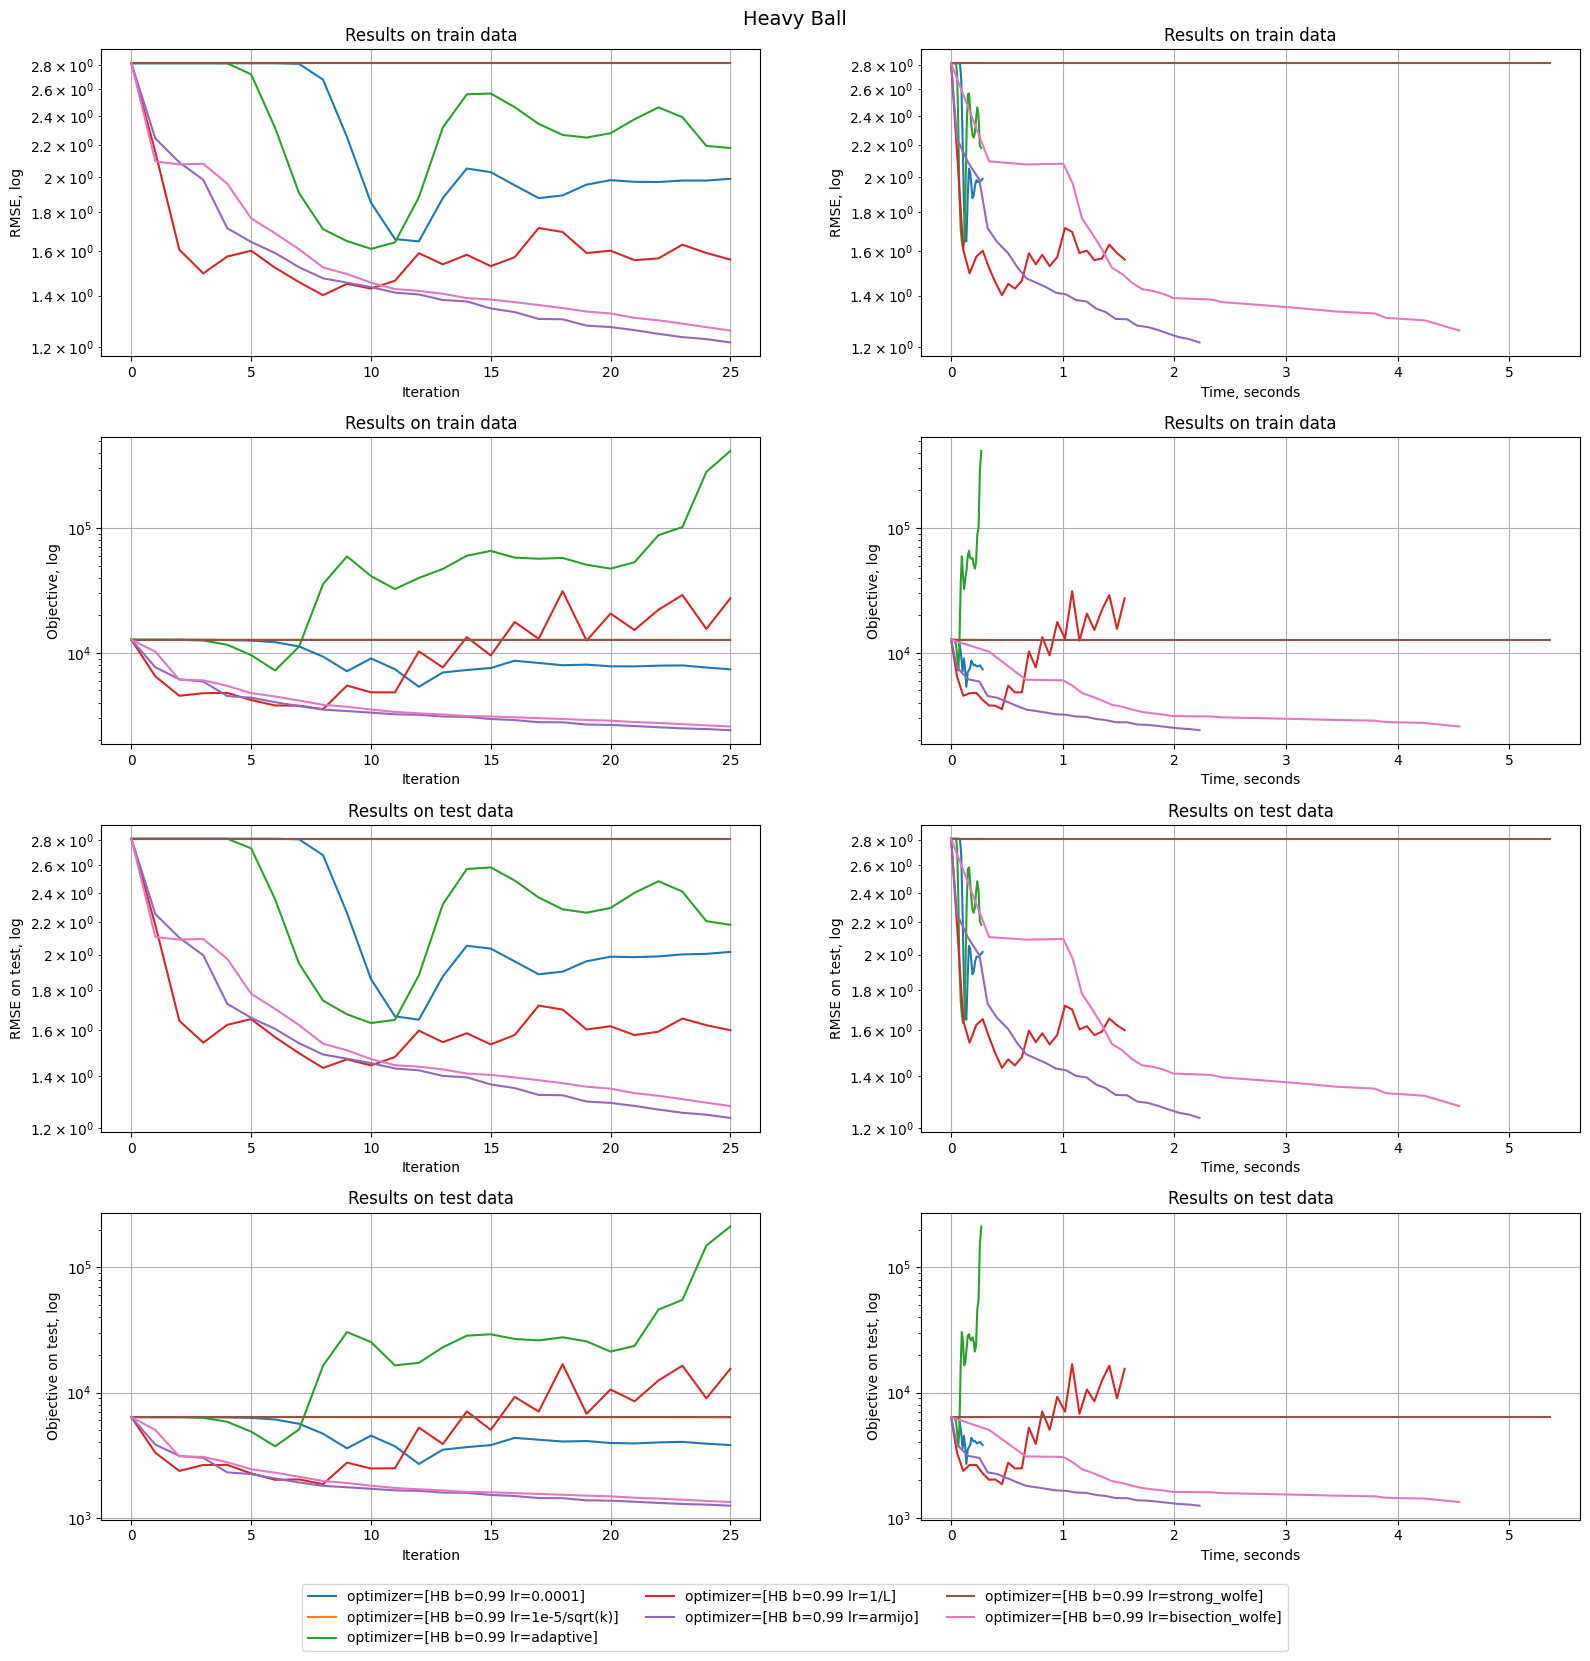

(tensor([[5.0000, 4.7242, 4.0455,  ..., 1.0815, 1.0000, 4.2069],
         [2.9309, 3.1367, 2.7195,  ..., 1.0000, 1.0000, 3.0107],
         [3.7943, 4.0562, 3.4816,  ..., 1.0000, 1.0000, 3.6589],
         ...,
         [3.6028, 3.7767, 3.2359,  ..., 1.0000, 1.0000, 3.5112],
         [3.0751, 3.2343, 2.7338,  ..., 1.0000, 1.0000, 3.0681],
         [3.0000, 2.5562, 2.2454,  ..., 1.0000, 1.0000, 3.4572]],
        device='cuda:0'),
 1.2367432117462158,
 25,
 2.2246503829956055,
 'optimizer=[HB b=0.99 lr=armijo]')

In [ ]:
hb_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler, beta=0.99)
                for lr_scheduler in [
                    Normal(1e-4),
                    Normal(lambda k: 1e-5 / np.sqrt(k), "1e-5/sqrt(k)"),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(hb_res[-1], "Heavy Ball")

hb_res[:-1]

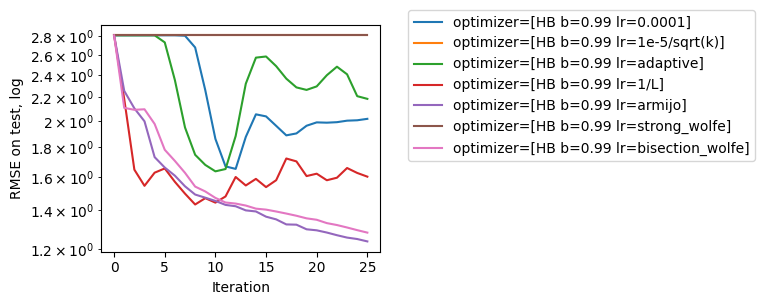

In [113]:
plot_log_dicts_test(hb_res[-1], "Heavy Ball")

Let's use Armijo for Heavy Ball method in future comparison


#### Nesterov


100%|██████████| 25/25 [00:03<00:00,  7.05it/s, Objective=2e+3, RMSE=1.1, Objective[test]=1.07e+3, RMSE[test]=1.13]    


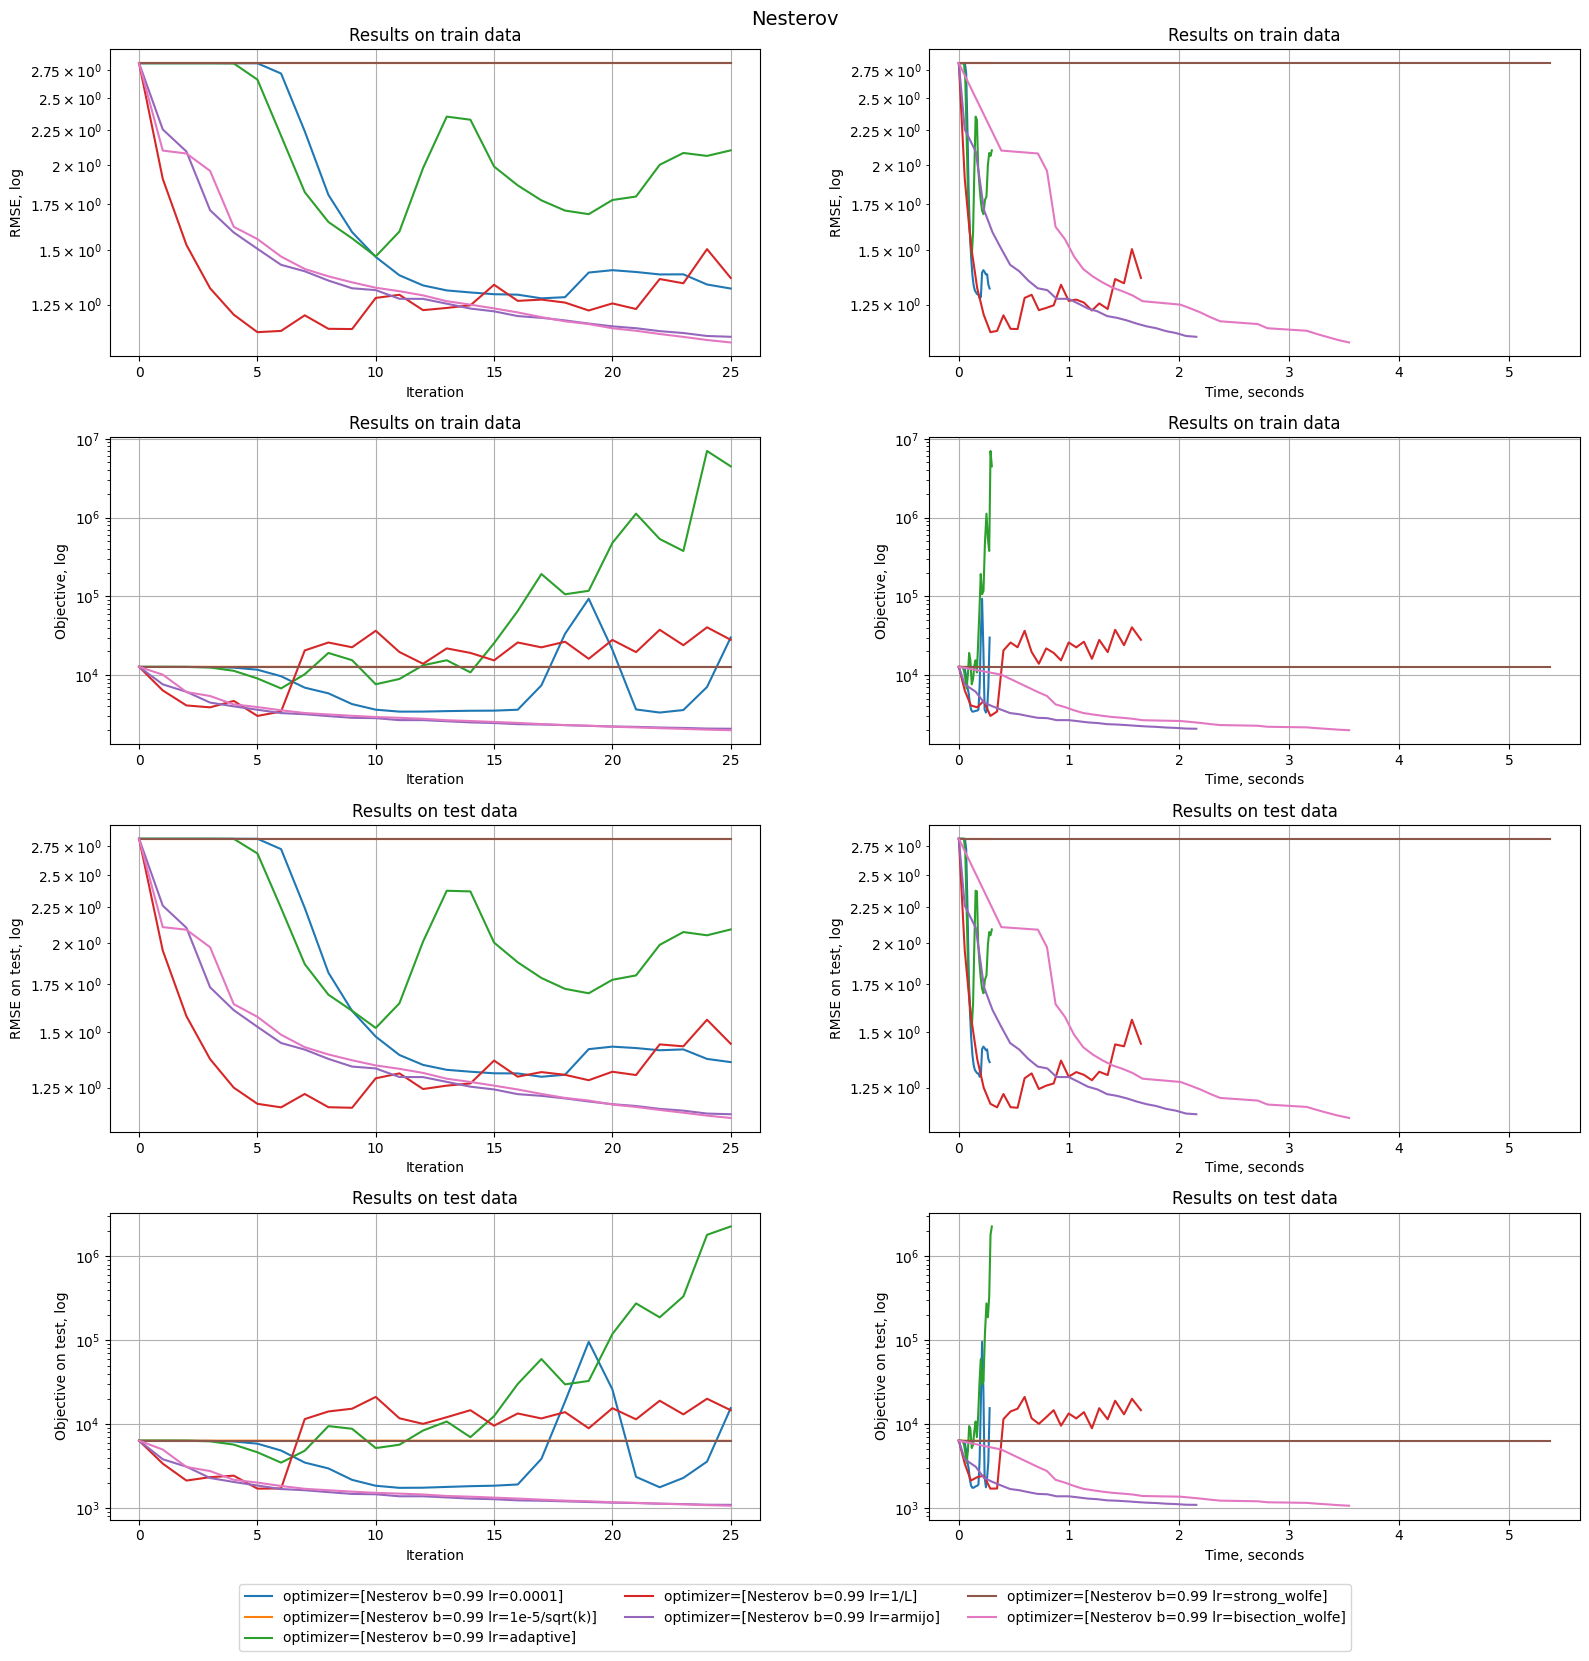

(tensor([[5.0000, 3.1400, 2.6925,  ..., 1.0000, 1.0000, 2.6902],
         [3.7181, 3.4071, 3.0063,  ..., 1.0302, 1.0000, 3.5626],
         [3.6069, 3.5332, 3.0267,  ..., 1.0000, 1.0000, 3.0992],
         ...,
         [4.0525, 3.7269, 3.1707,  ..., 1.0000, 1.0000, 3.5451],
         [3.9076, 3.3688, 2.8593,  ..., 1.1334, 1.0000, 3.5092],
         [3.0000, 1.2020, 1.0477,  ..., 1.3603, 1.0113, 3.6153]],
        device='cuda:0'),
 1.1323741674423218,
 25,
 3.5472311973571777,
 'optimizer=[Nesterov b=0.99 lr=bisection_wolfe]')

In [ ]:
nesterov_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler, beta=0.99, nesterov=True)
                for lr_scheduler in [
                    Normal(1e-4),
                    Normal(lambda k: 1e-5 / np.sqrt(k), "1e-5/sqrt(k)"),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(nesterov_res[-1], "Nesterov")

nesterov_res[:-1]

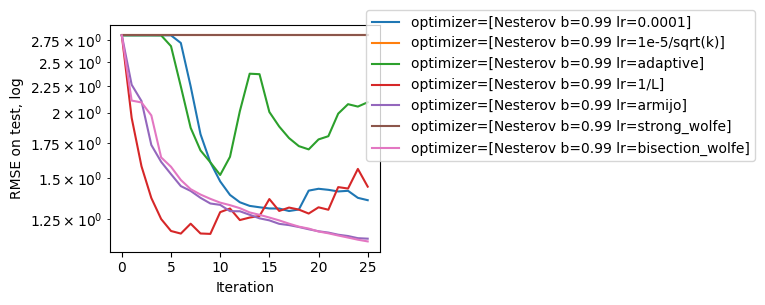

In [115]:
plot_log_dicts_test(nesterov_res[-1], "Nesterov")

Bisection wolfe slightly outperforms Armijo, but Armijo works much faster.
Let's use Nesterov with Armijo strategy for future comparison


#### RMSProp


100%|██████████| 25/25 [00:12<00:00,  2.03it/s, Objective=1.06e+3, RMSE=0.855, Objective[test]=602, RMSE[test]=0.905] 


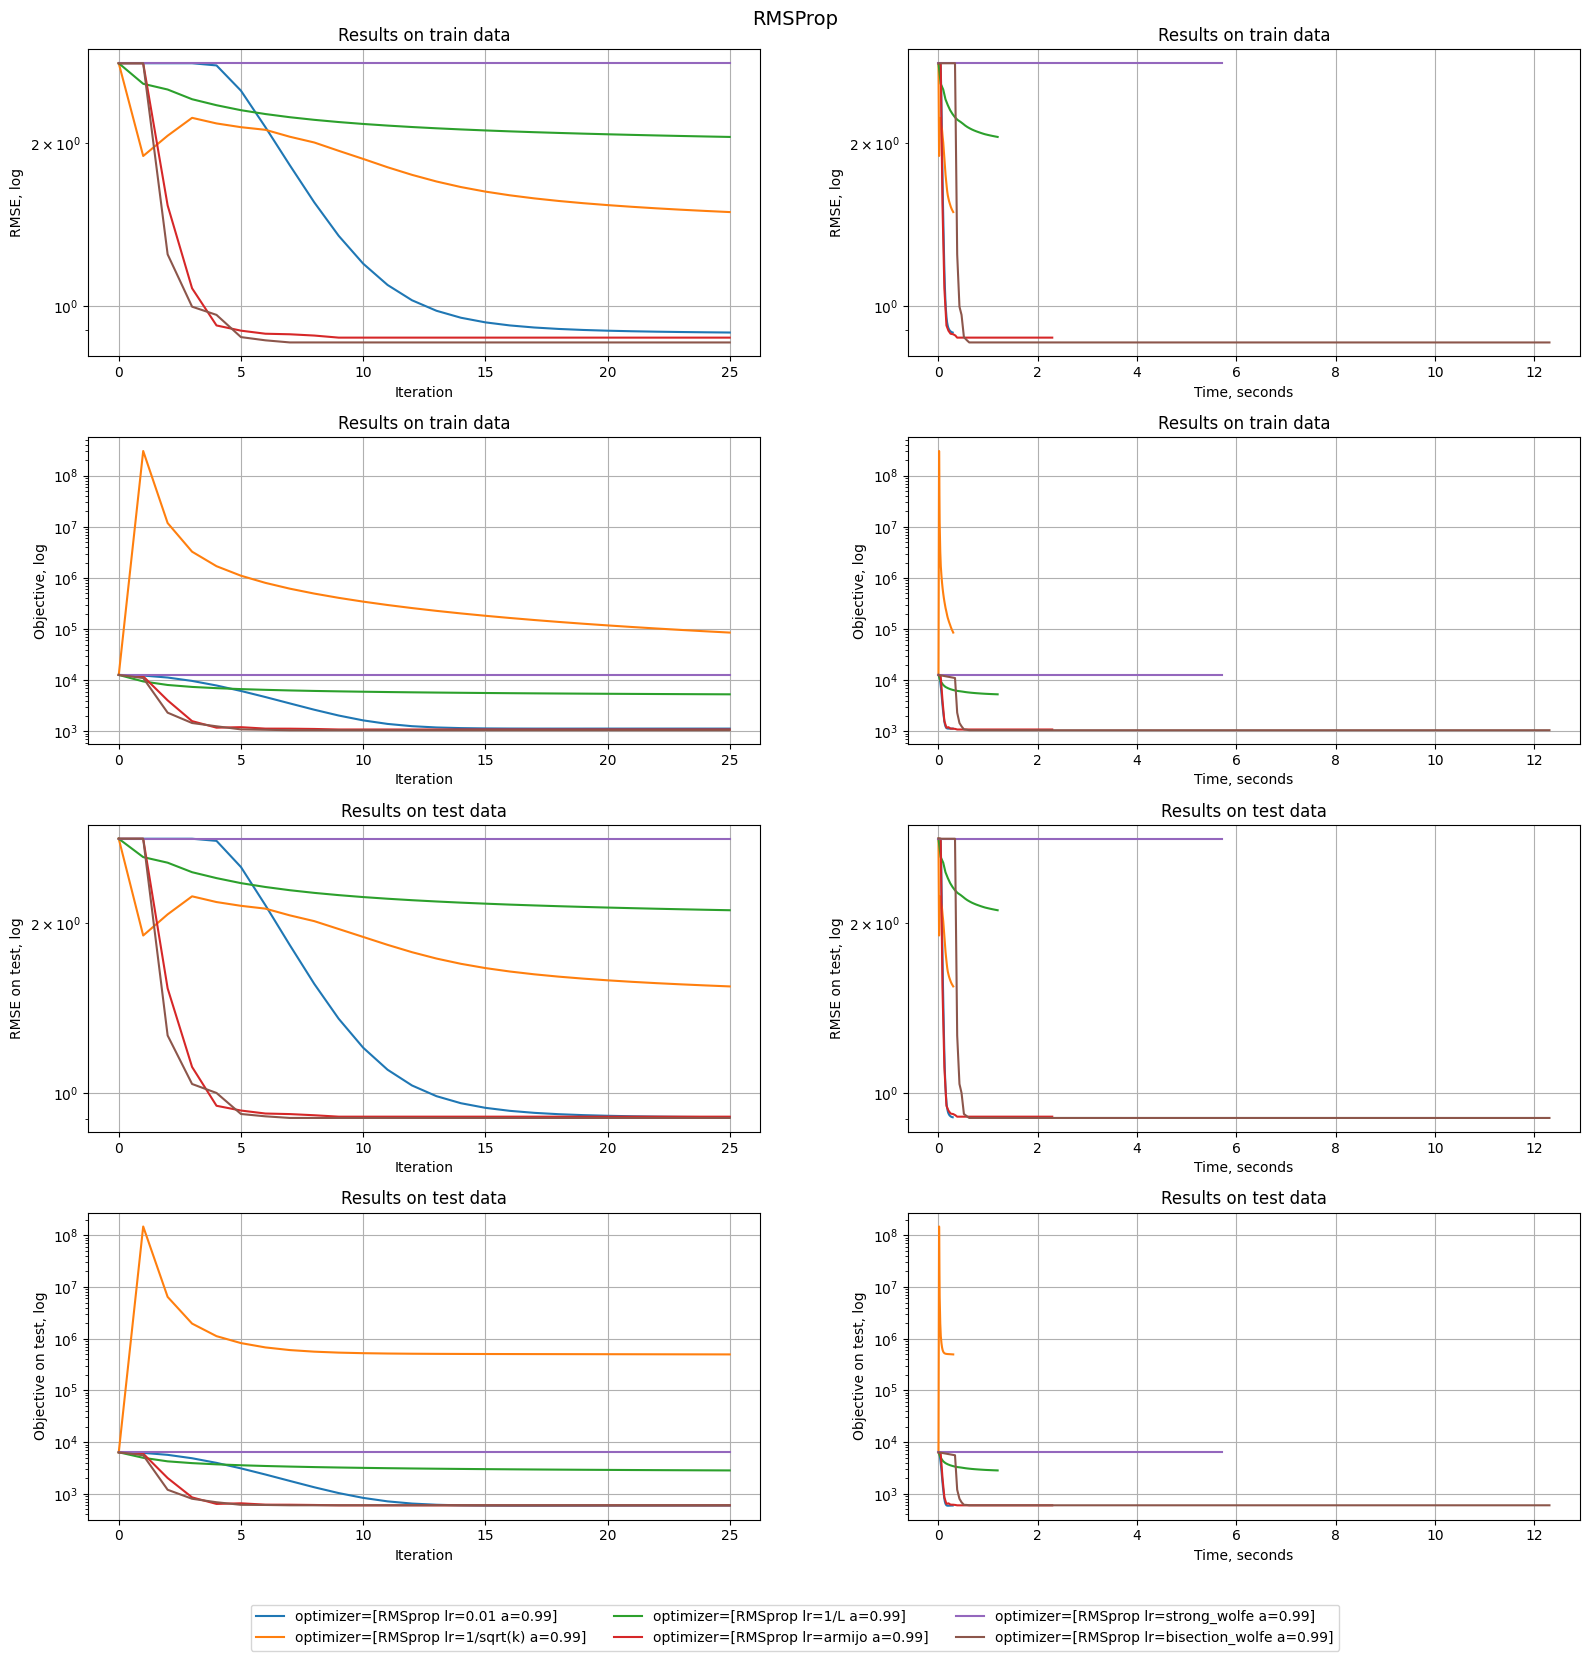

(tensor([[5.0000, 3.8763, 3.7636,  ..., 3.5247, 4.2520, 3.8348],
         [3.8135, 3.1161, 2.9379,  ..., 3.7623, 4.0999, 3.7634],
         [4.5724, 3.3325, 3.0897,  ..., 3.1446, 3.7985, 3.3863],
         ...,
         [4.2354, 2.9861, 2.8373,  ..., 2.7019, 3.5748, 3.0737],
         [4.1479, 3.2520, 3.0253,  ..., 3.0433, 3.8120, 3.3807],
         [3.0000, 2.8875, 2.7555,  ..., 3.5457, 4.0976, 3.7786]],
        device='cuda:0'),
 0.9053924083709717,
 25,
 12.30682897567749,
 'optimizer=[RMSprop lr=bisection_wolfe a=0.99]')

In [ ]:
rmsprop_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                RMSprop(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-2),
                    Normal(lambda k: 1 / np.sqrt(k), "1/sqrt(k)"),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(rmsprop_res[-1], "RMSProp")

rmsprop_res[:-1]

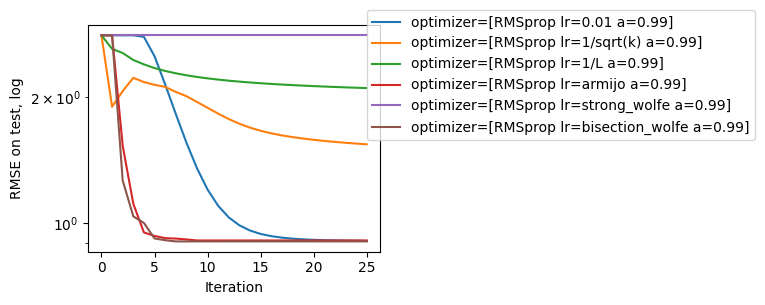

In [116]:
plot_log_dicts_test(rmsprop_res[-1], "RMSProp")

Bisection wolfe slightly outperforms Armijo, but Armijo works faster.
Let's use RMSProp with Armijo strategy for future comparison


#### AdaGrad


100%|██████████| 25/25 [00:11<00:00,  2.22it/s, Objective=1.07e+3, RMSE=0.865, Objective[test]=608, RMSE[test]=0.914] 


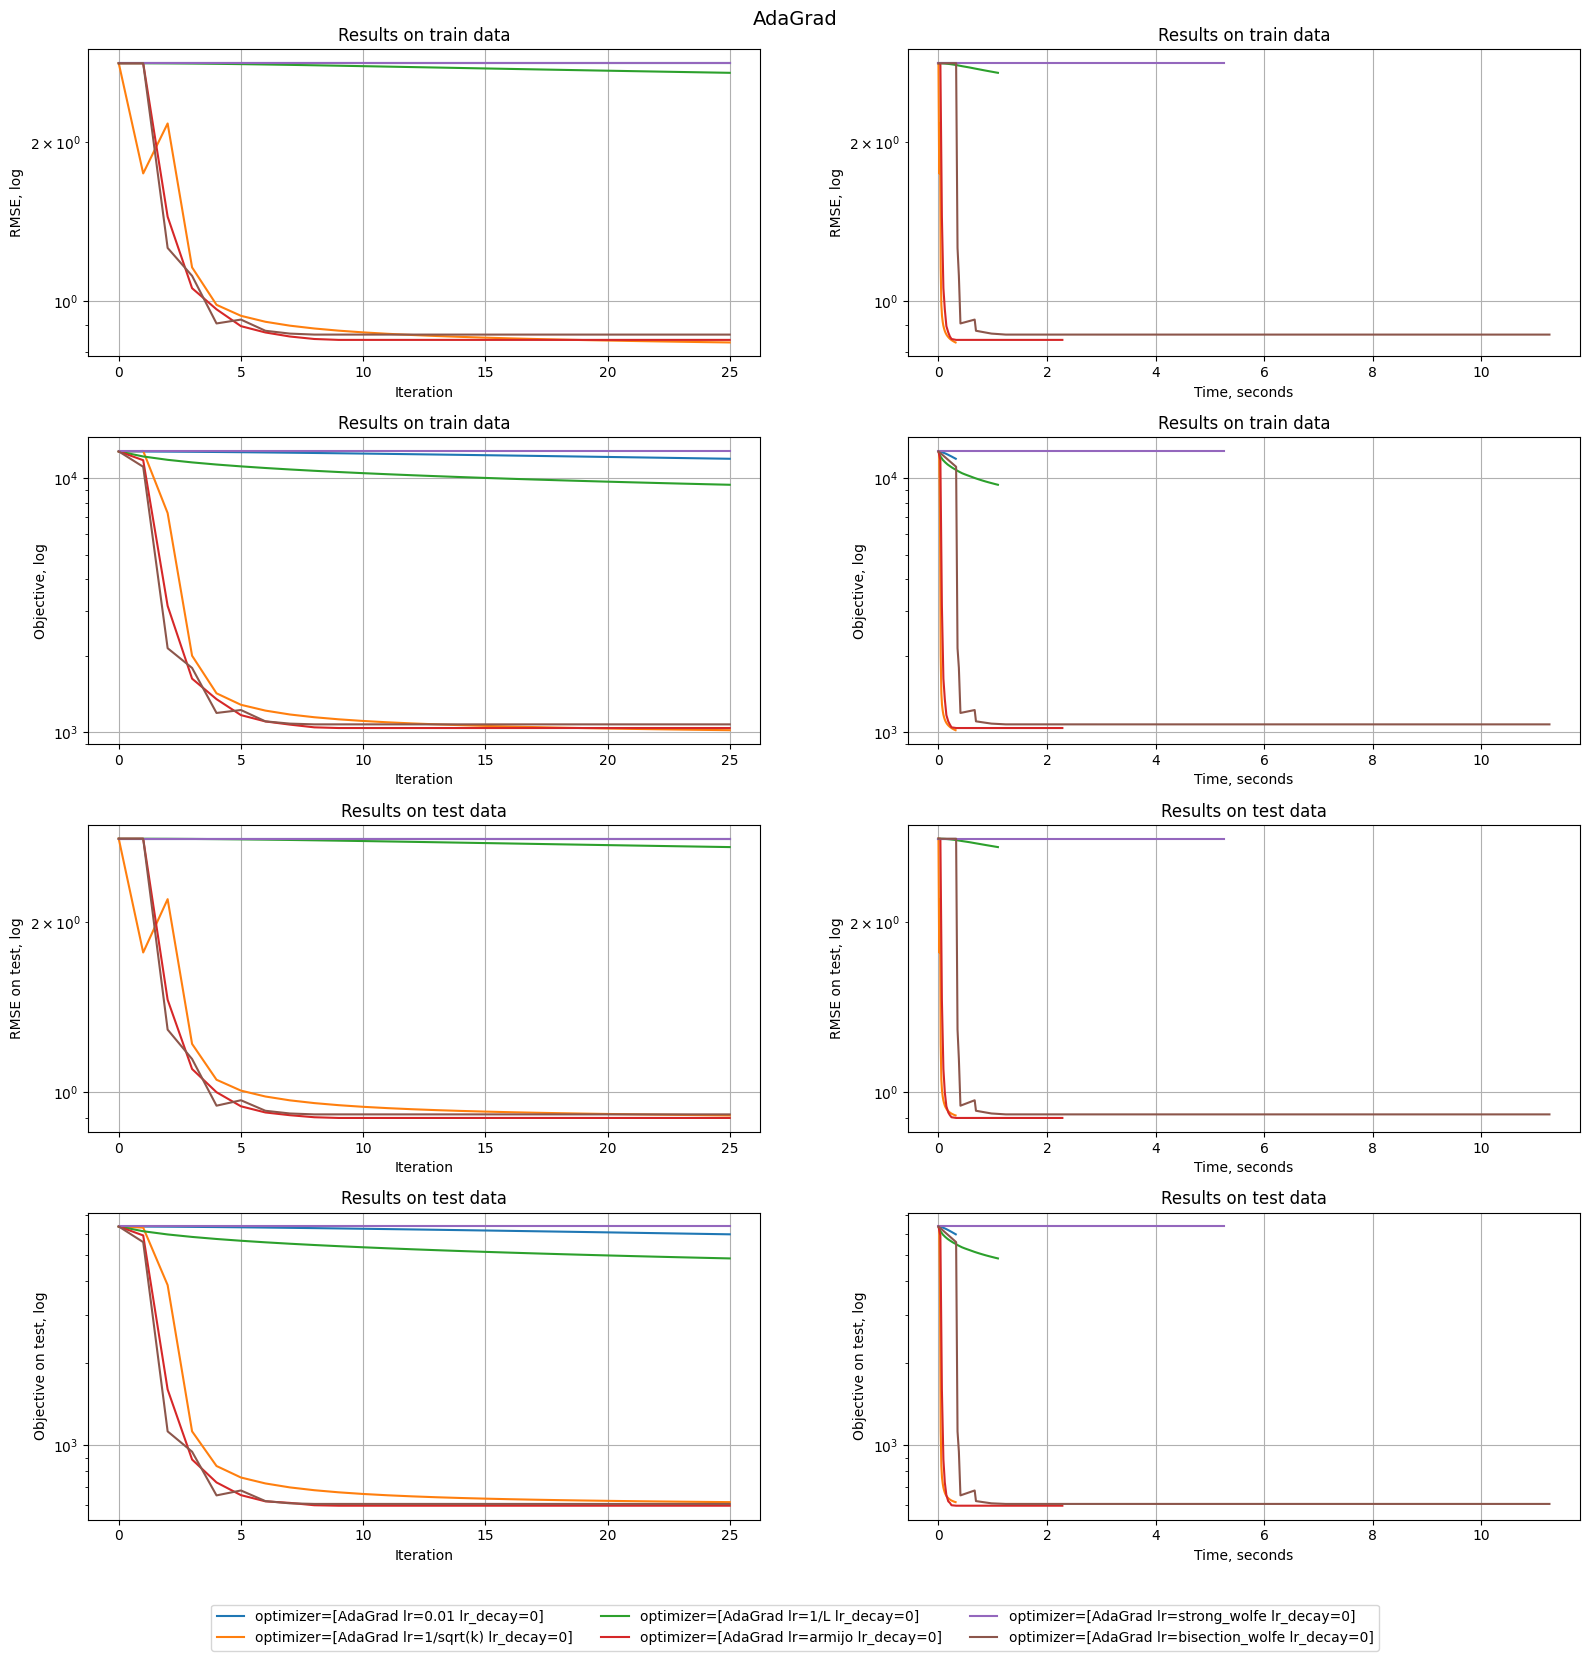

(tensor([[5.0000, 3.7149, 3.7191,  ..., 3.7590, 3.7629, 3.2553],
         [3.8917, 3.0976, 2.8535,  ..., 3.7169, 3.8214, 3.4563],
         [4.2281, 3.3115, 2.8761,  ..., 3.2147, 3.6828, 3.2588],
         ...,
         [4.1853, 2.9985, 2.9217,  ..., 2.8894, 3.4865, 2.9170],
         [4.2419, 3.2701, 3.0287,  ..., 3.2439, 3.6224, 3.1345],
         [3.0000, 2.7406, 2.6148,  ..., 3.4123, 3.9970, 3.6364]],
        device='cuda:0'),
 0.9008955359458923,
 10,
 0.427570104598999,
 'optimizer=[AdaGrad lr=armijo lr_decay=0]')

In [ ]:
adagrad_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                AdaGrad(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-2),
                    Normal(lambda k: 1 / np.sqrt(k), "1/sqrt(k)"),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(adagrad_res[-1], "AdaGrad")

adagrad_res[:-1]

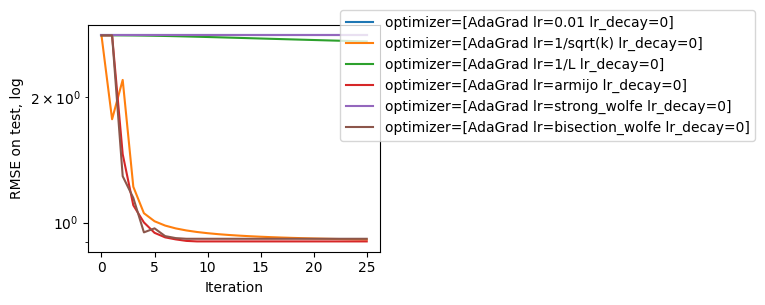

In [117]:
plot_log_dicts_test(adagrad_res[-1], "AdaGrad")

Bisection wolfe slightly outperforms Armijo, but Armijo works much faster.
Let's use AdaGrad with Armijo strategy for future comparison


#### Adam


100%|██████████| 25/25 [00:02<00:00, 11.84it/s, Objective=1.17e+3, RMSE=0.886, Objective[test]=691, RMSE[test]=0.947] 


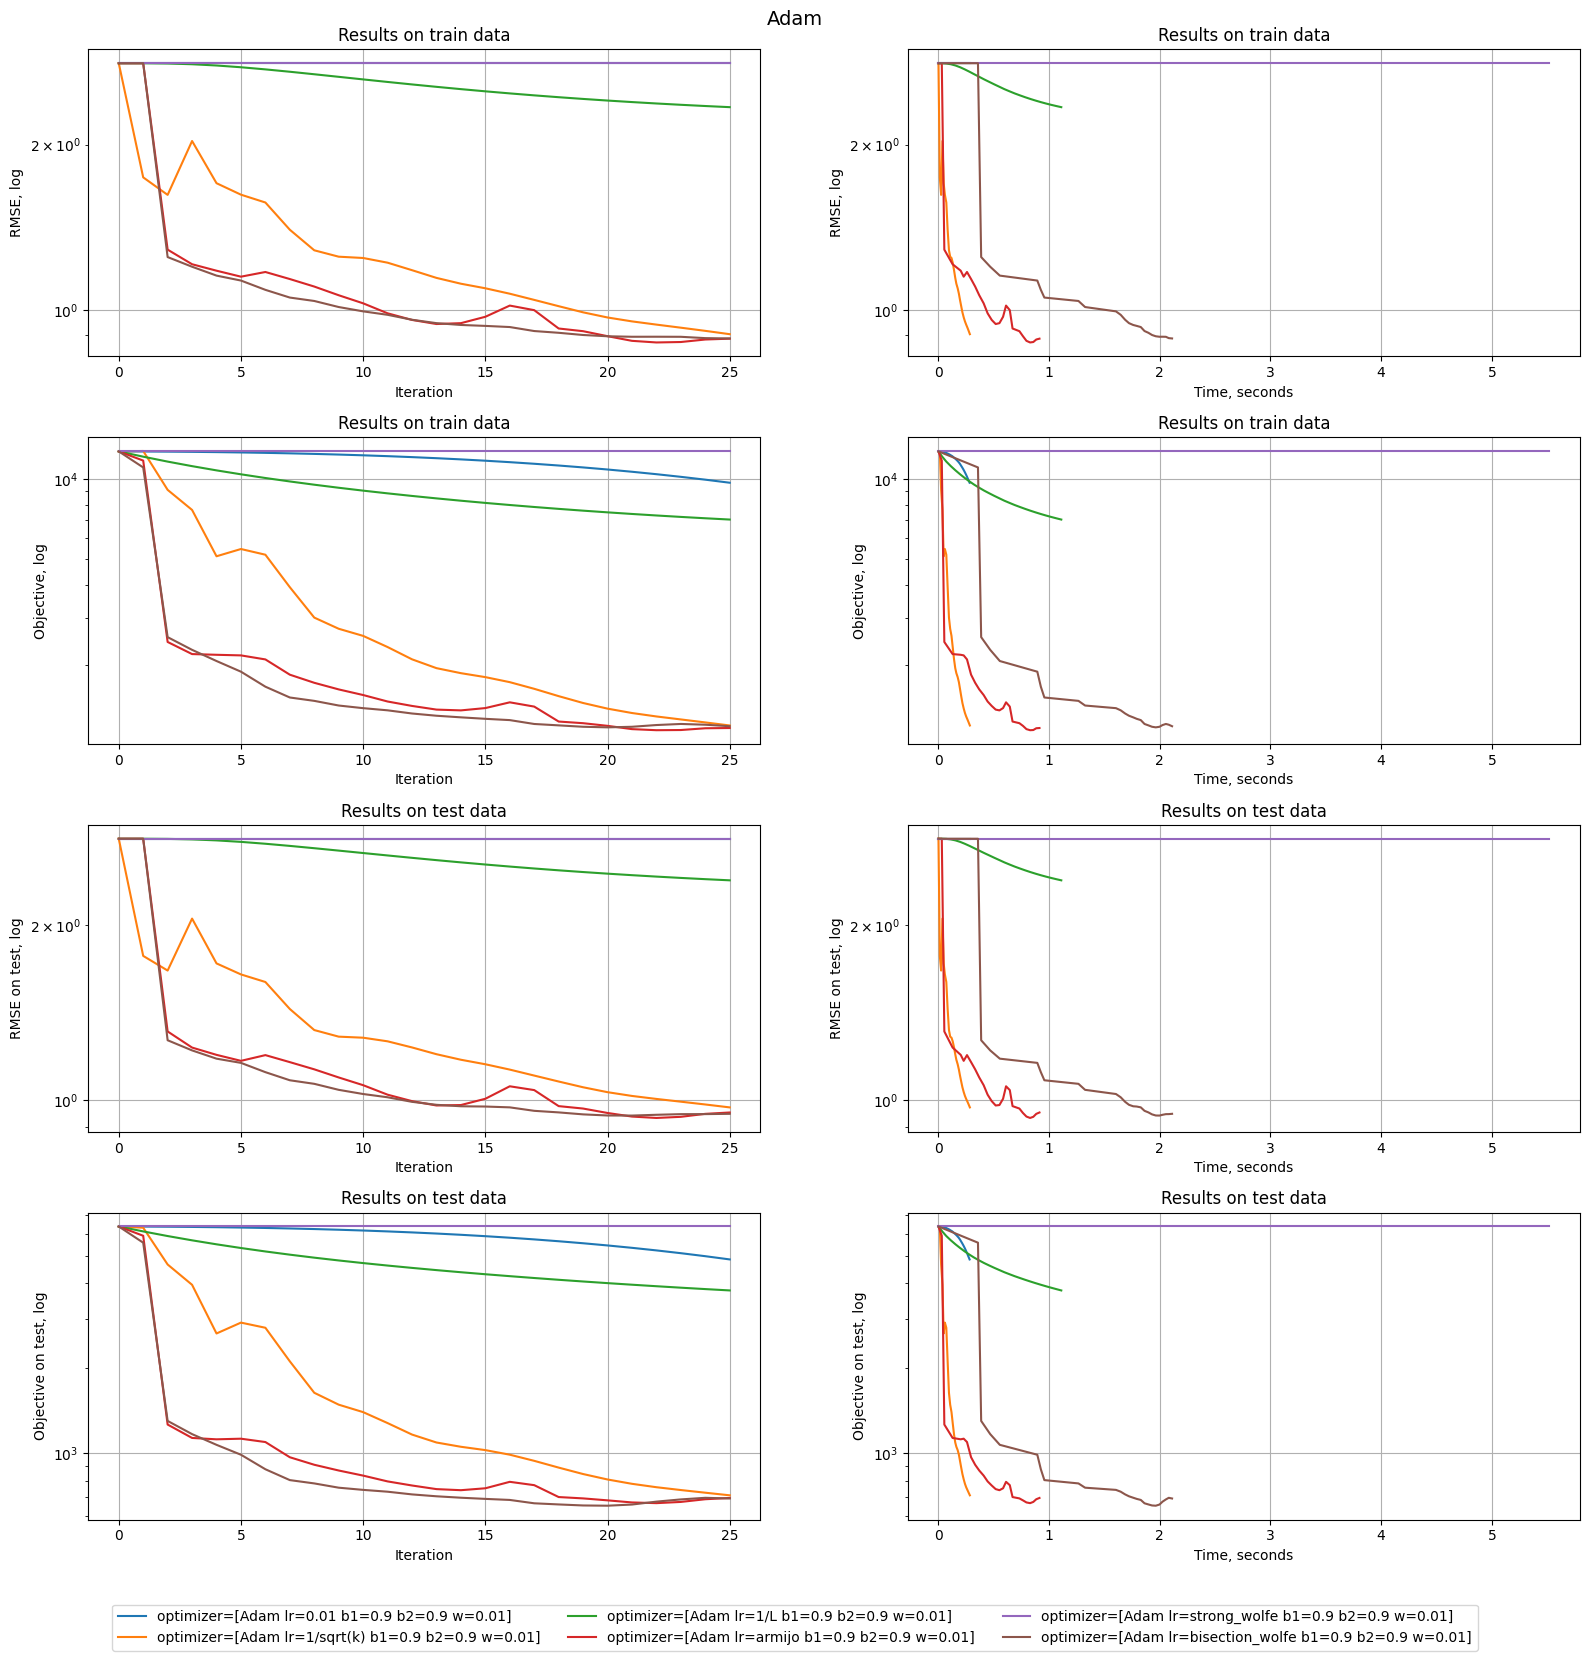

(tensor([[5.0000, 3.1875, 3.5785,  ..., 3.6109, 3.4502, 3.6282],
         [3.7251, 2.8583, 2.4691,  ..., 3.4774, 3.7721, 3.7787],
         [4.1325, 3.3024, 3.2741,  ..., 4.4816, 3.7635, 4.5407],
         ...,
         [2.5637, 1.8629, 1.8562,  ..., 3.5528, 3.8150, 3.0421],
         [3.7672, 2.6245, 2.6450,  ..., 3.5045, 3.9012, 3.6835],
         [3.0000, 2.0377, 1.7633,  ..., 3.1080, 4.4493, 3.7186]],
        device='cuda:0'),
 0.9315246939659119,
 22,
 0.8277864456176758,
 'optimizer=[Adam lr=armijo b1=0.9 b2=0.9 w=0.01]')

In [ ]:
adam_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 25,
        "init_strategy": "svd",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                Adam(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-2),
                    Normal(lambda k: 1 / np.sqrt(k), "1/sqrt(k)"),
                    Estimate1OverL(),
                    Armijo(),
                    StrongWolfe(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(adam_res[-1], "Adam")

adam_res[:-1]

In [120]:
len("b1=0.9 b2=0.9 w=0.01")

20

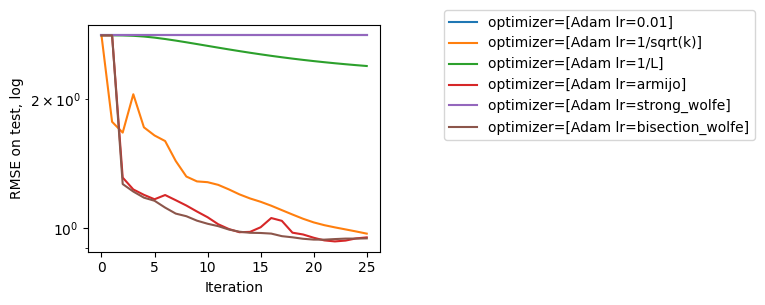

In [ ]:
plot_log_dicts_test({k[:-22] + "]": v for k, v in adam_res[-1].items()}, "Adam")

Let's choose 1/sqrt(k) for Adam optimizer for future comparison


#### Optimizers comparison


100%|██████████| 150/150 [00:01<00:00, 99.74it/s, Objective=839, RMSE=0.747, Objective[test]=633, RMSE[test]=0.889]      


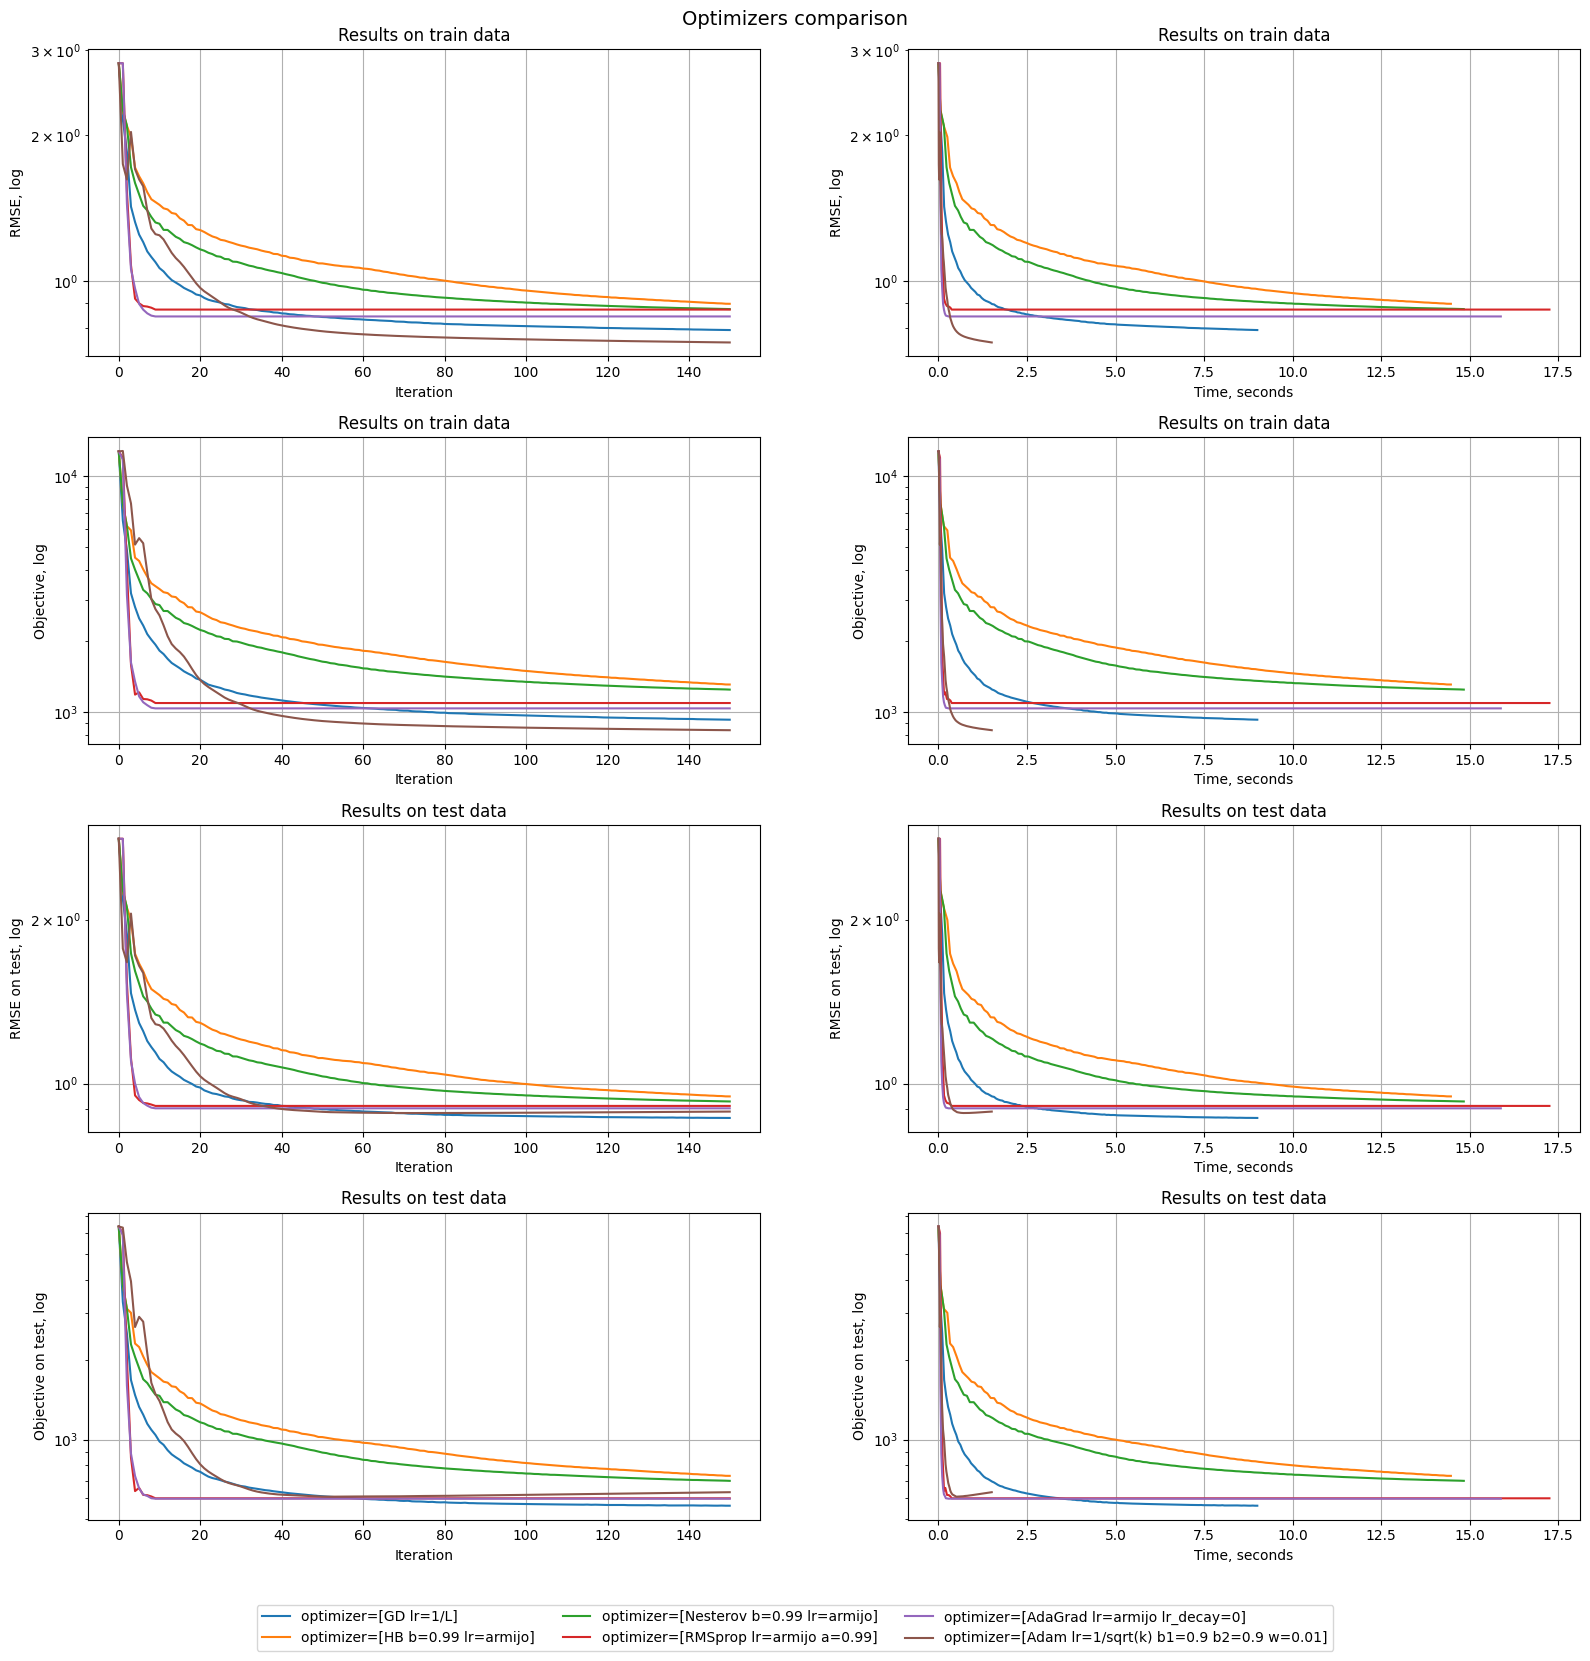

(tensor([[5.0000, 3.5044, 3.1241,  ..., 2.9598, 2.8802, 3.6214],
         [4.0999, 3.1324, 3.0883,  ..., 3.1829, 2.9603, 3.8700],
         [4.1083, 3.2843, 3.3044,  ..., 3.0601, 2.7453, 3.8134],
         ...,
         [3.6687, 2.6705, 2.5627,  ..., 2.8529, 2.8613, 3.5581],
         [3.9696, 2.8681, 2.4624,  ..., 3.0419, 3.1777, 3.4783],
         [3.0000, 1.6098, 1.0000,  ..., 3.1830, 4.0300, 3.4333]],
        device='cuda:0'),
 0.8650059700012207,
 150,
 9.003117084503174,
 'optimizer=[GD lr=1/L]')

In [ ]:
opt_comp_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 150,
        "init_strategy": "svd",
        "optimizer": [
            GradientDescent(lr_scheduler=Estimate1OverL()),
            GradientDescent(lr_scheduler=Armijo(), beta=0.99),
            GradientDescent(lr_scheduler=Armijo(), beta=0.99, nesterov=True),
            RMSprop(lr_scheduler=Armijo()),
            AdaGrad(lr_scheduler=Armijo()),
            Adam(lr_scheduler=Normal(lambda k: 1 / np.sqrt(k), "1/sqrt(k)")),
        ],
        "regularization": 0.1,
        "verbose": True,
    },
)

plot_log_dicts(opt_comp_res[-1], "Optimizers comparison")

opt_comp_res[:-1]

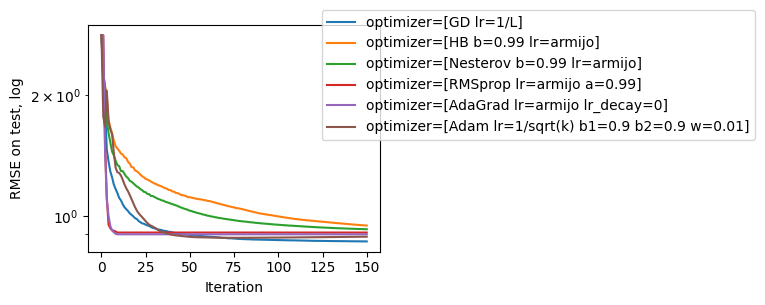

In [124]:
plot_log_dicts_test(opt_comp_res[-1], "Optimizers comparison")

As we can see, Gradient descent update shows the best performance in terms of score. Let's tune its hyperparameters to find best of them.


#### Tuning parameters for best optimizer + lr strategy


100%|██████████| 250/250 [00:13<00:00, 18.05it/s, Objective=774, RMSE=0.721, Objective[test]=581, RMSE[test]=0.871]    


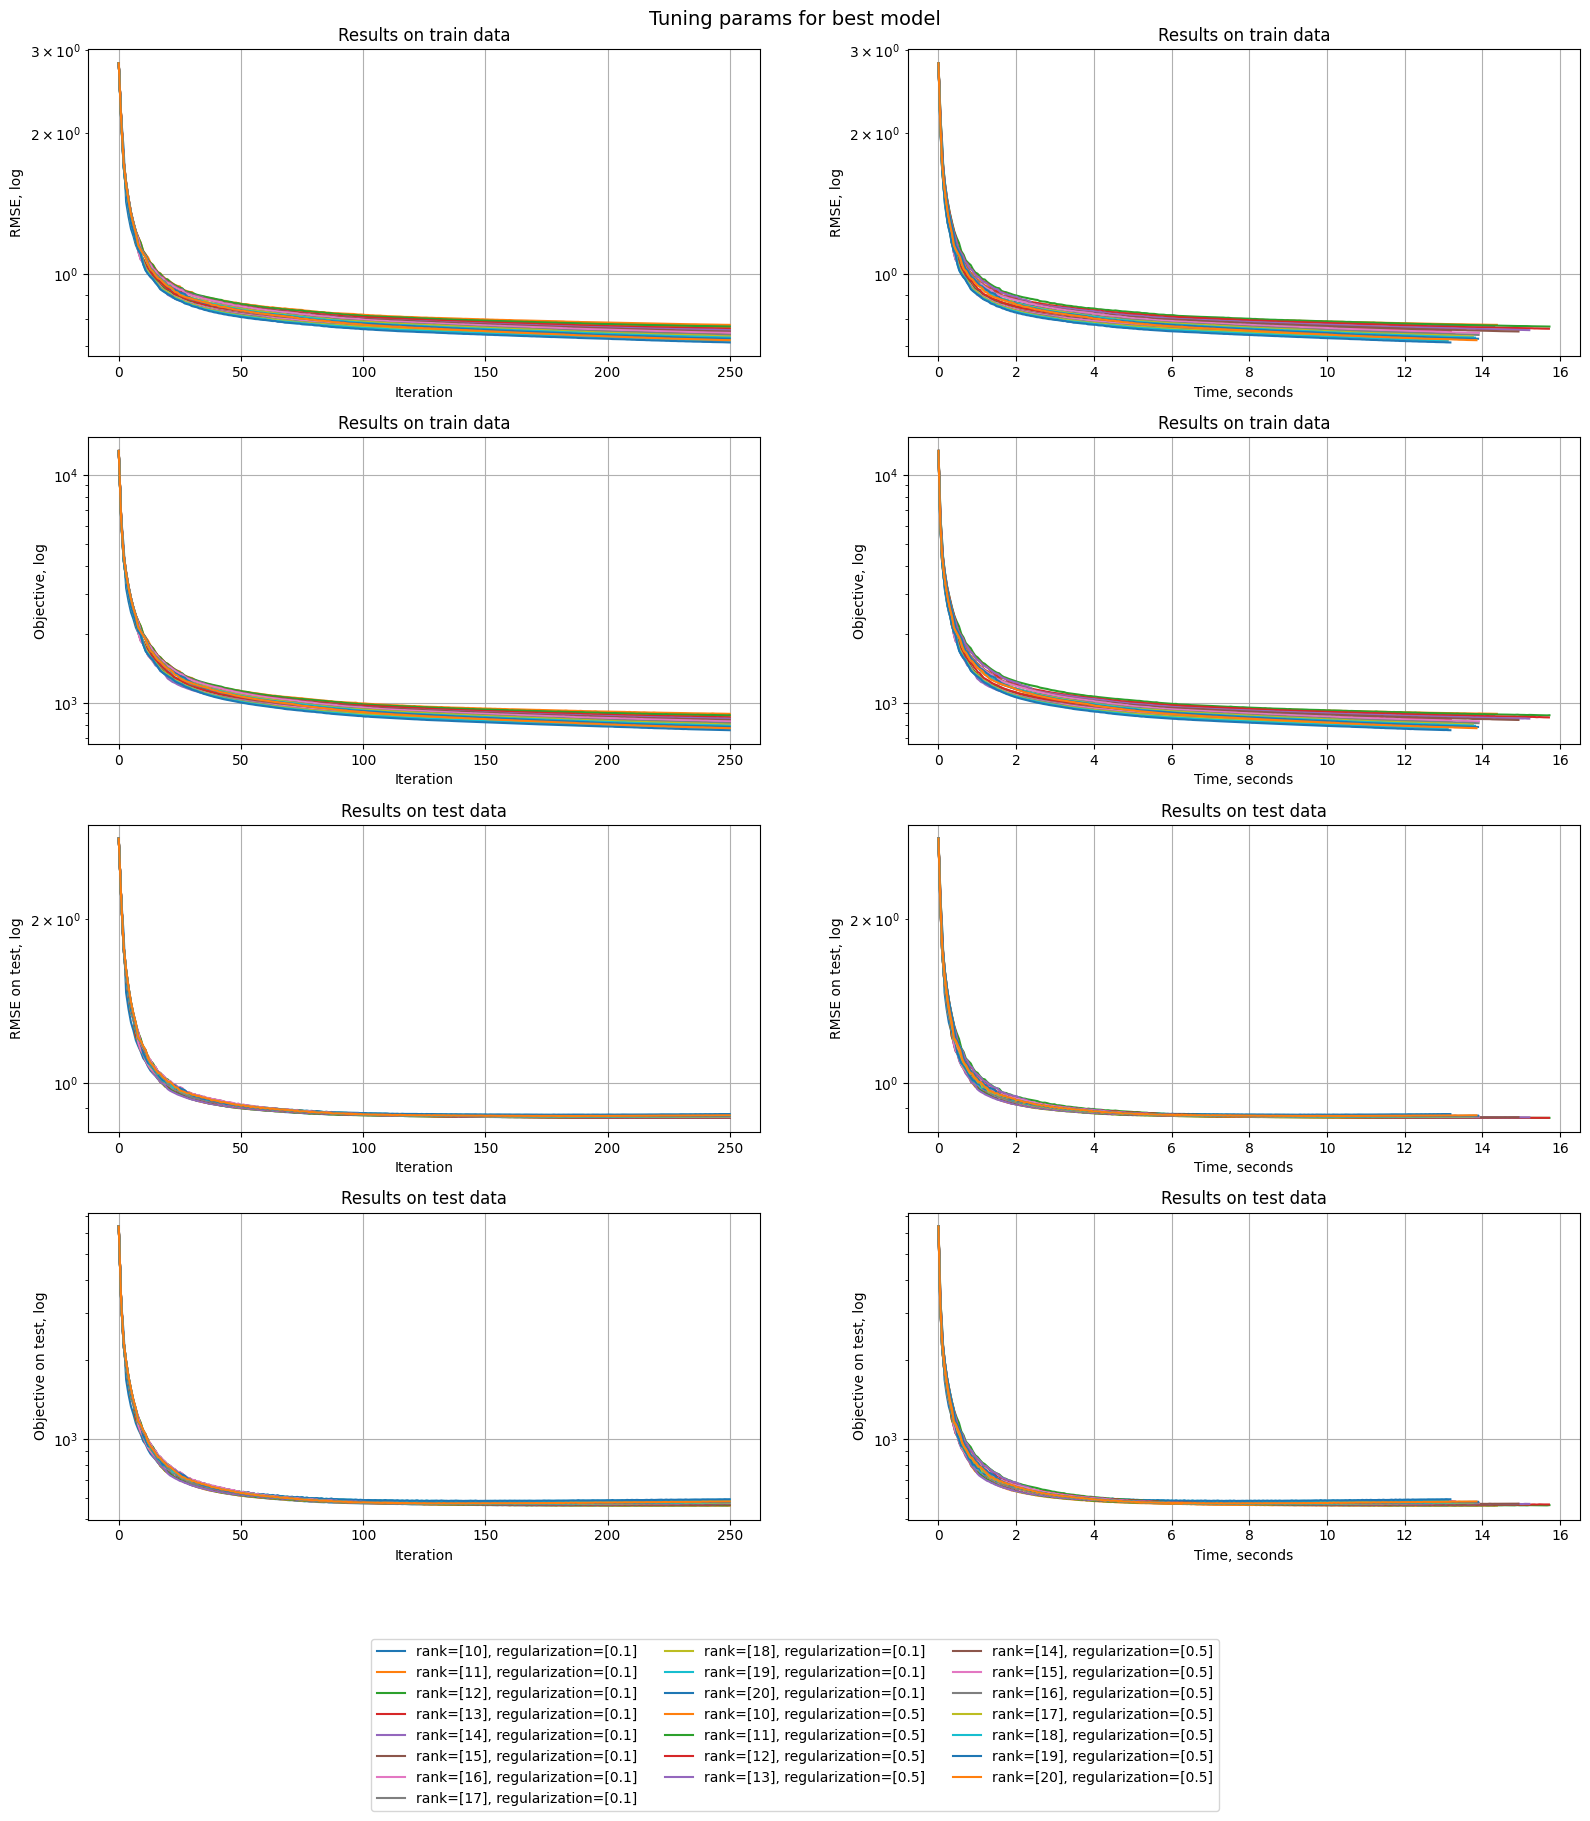

(tensor([[5.0000, 3.5278, 3.1639,  ..., 3.2768, 3.2186, 3.7795],
         [4.1758, 3.2491, 3.1998,  ..., 3.4137, 3.1548, 3.8832],
         [4.1589, 3.3251, 3.3845,  ..., 3.3150, 3.0628, 3.8386],
         ...,
         [3.7285, 2.7700, 2.6632,  ..., 3.1175, 3.2572, 3.7490],
         [4.0479, 2.9073, 2.5425,  ..., 3.2421, 3.4916, 3.6759],
         [3.0000, 1.5569, 1.0000,  ..., 3.0418, 4.0696, 3.4562]],
        device='cuda:0'),
 0.861275315284729,
 247,
 14.18144178390503,
 'rank=[10], regularization=[0.5]')

In [28]:
best_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        "iterations": 250,
        "init_strategy": "svd",
        "optimizer": GradientDescent(lr_scheduler=Estimate1OverL()),
        "regularization": [0.1, 0.5],
        "verbose": True,
    },
)

plot_log_dicts(best_res[-1], "Tuning params for best model")

best_res[:-1]

As we can see, the best perfoming rank is 10 with regularization 0.5. Let's check lower ranks.


100%|██████████| 250/250 [00:13<00:00, 18.47it/s, Objective=896, RMSE=0.778, Objective[test]=560, RMSE[test]=0.861]    


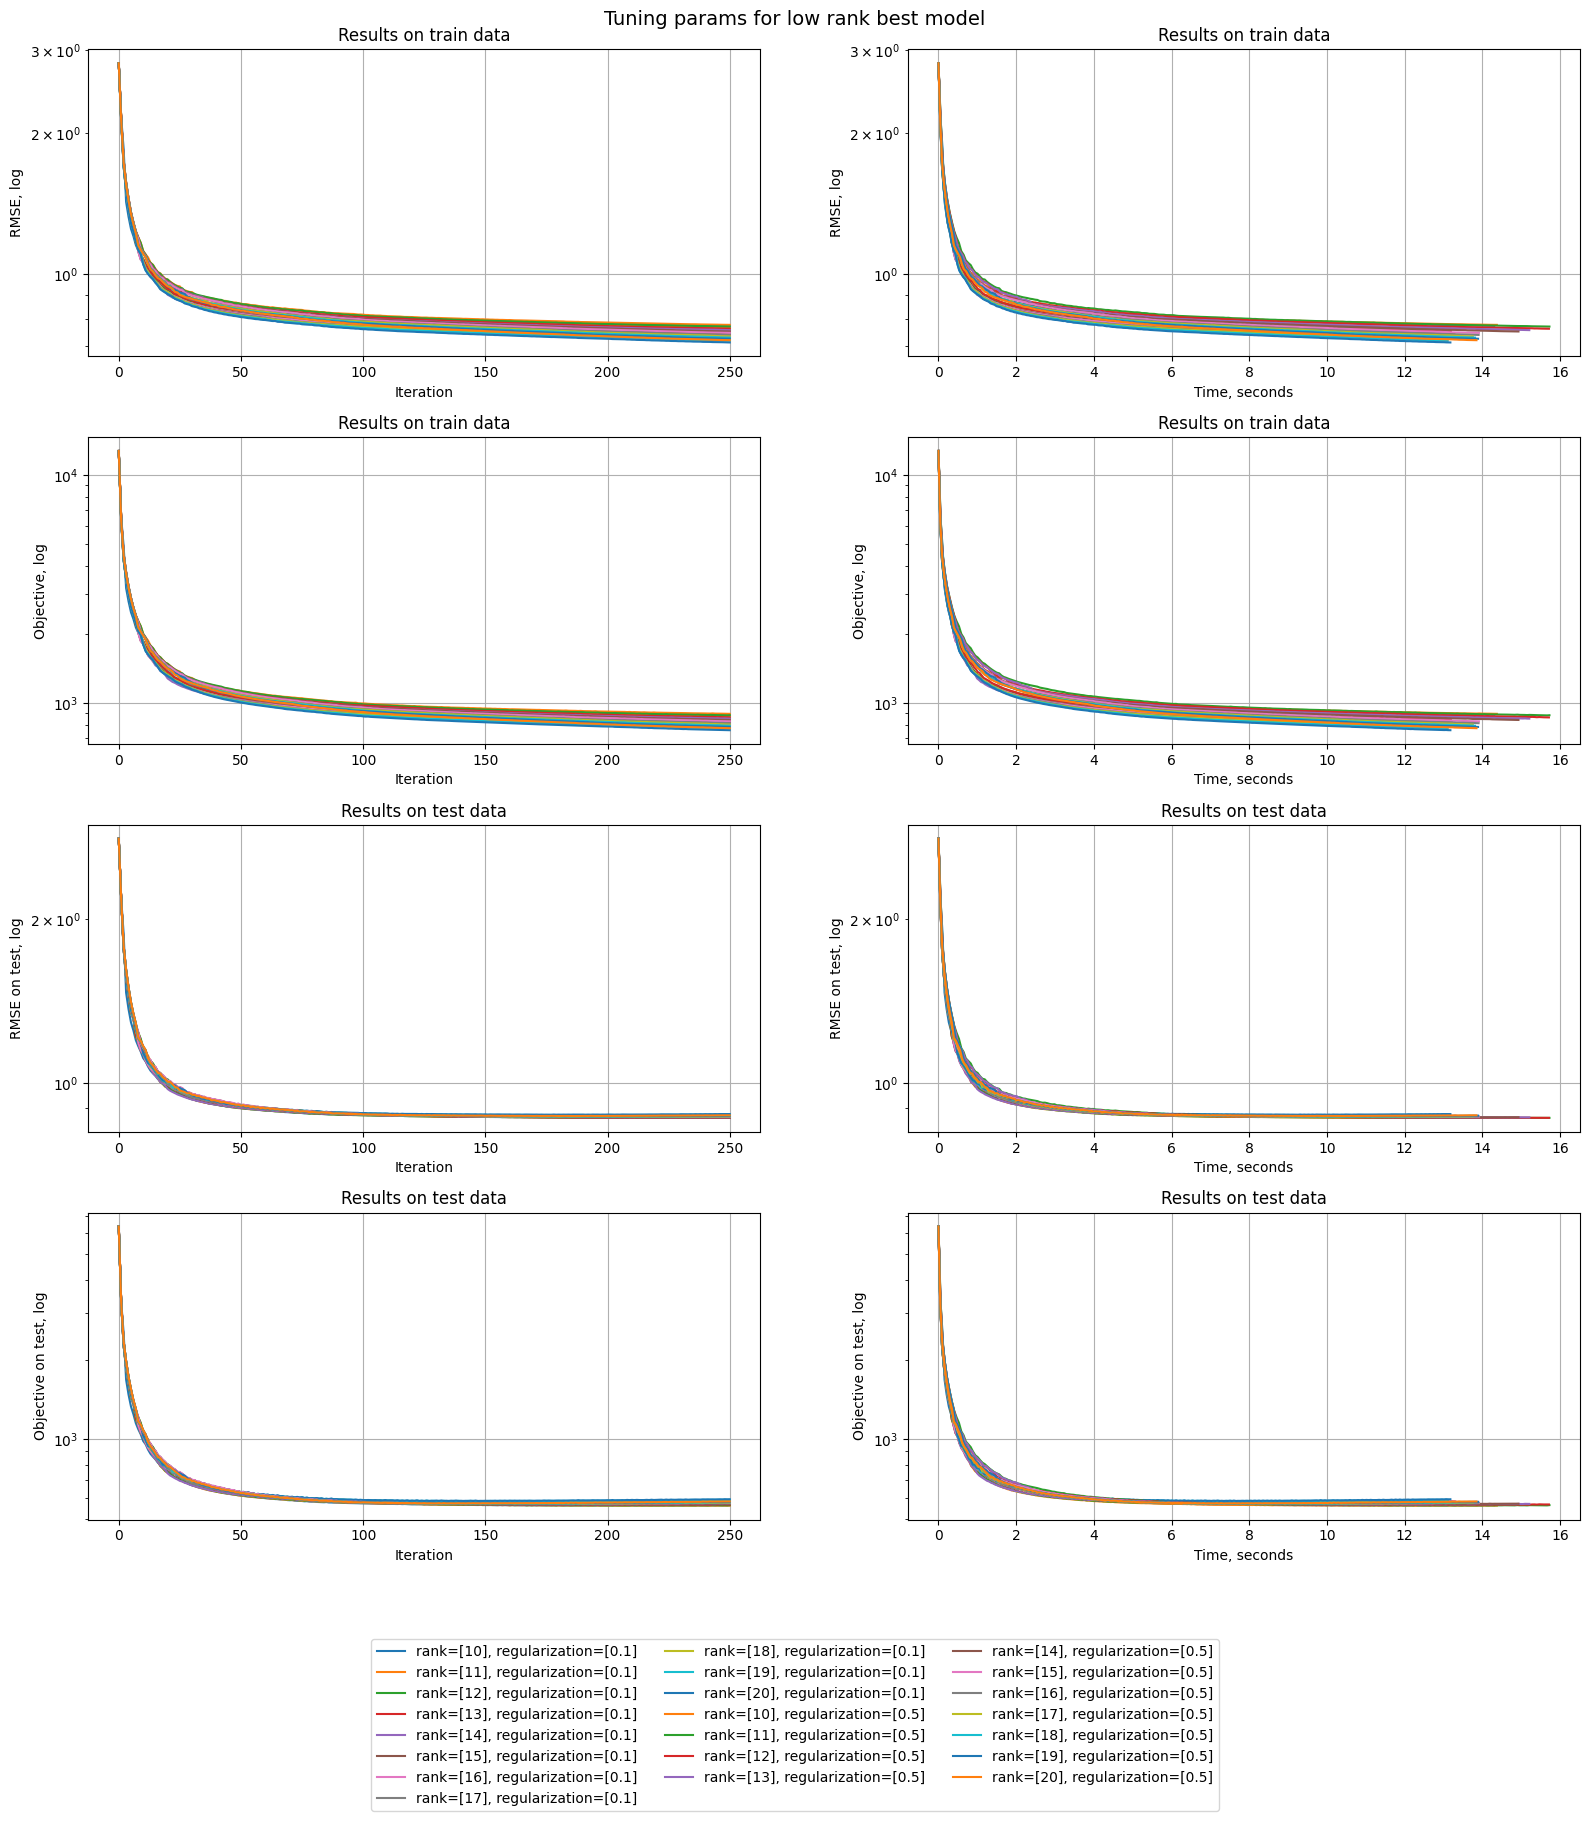

(tensor([[5.0000, 3.5278, 3.1639,  ..., 3.2768, 3.2186, 3.7795],
         [4.1758, 3.2491, 3.1998,  ..., 3.4137, 3.1548, 3.8832],
         [4.1589, 3.3251, 3.3845,  ..., 3.3150, 3.0628, 3.8386],
         ...,
         [3.7285, 2.7700, 2.6632,  ..., 3.1175, 3.2572, 3.7490],
         [4.0479, 2.9073, 2.5425,  ..., 3.2421, 3.4916, 3.6759],
         [3.0000, 1.5569, 1.0000,  ..., 3.0418, 4.0696, 3.4562]],
        device='cuda:0'),
 0.861275315284729,
 247,
 13.367609739303589,
 'rank=[10], regularization=[0.5]')

In [29]:
best_low_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "iterations": 250,
        "init_strategy": "svd",
        "optimizer": GradientDescent(lr_scheduler=Estimate1OverL()),
        "regularization": [0.1, 0.5],
        "verbose": True,
    },
)

plot_log_dicts(best_res[-1], "Tuning params for low rank best model")

best_low_res[:-1]

Once again, rank 10 showed the best performance. Now let's tune regularization parameter.


100%|██████████| 250/250 [00:14<00:00, 17.60it/s, Objective=939, RMSE=0.802, Objective[test]=563, RMSE[test]=0.87]     


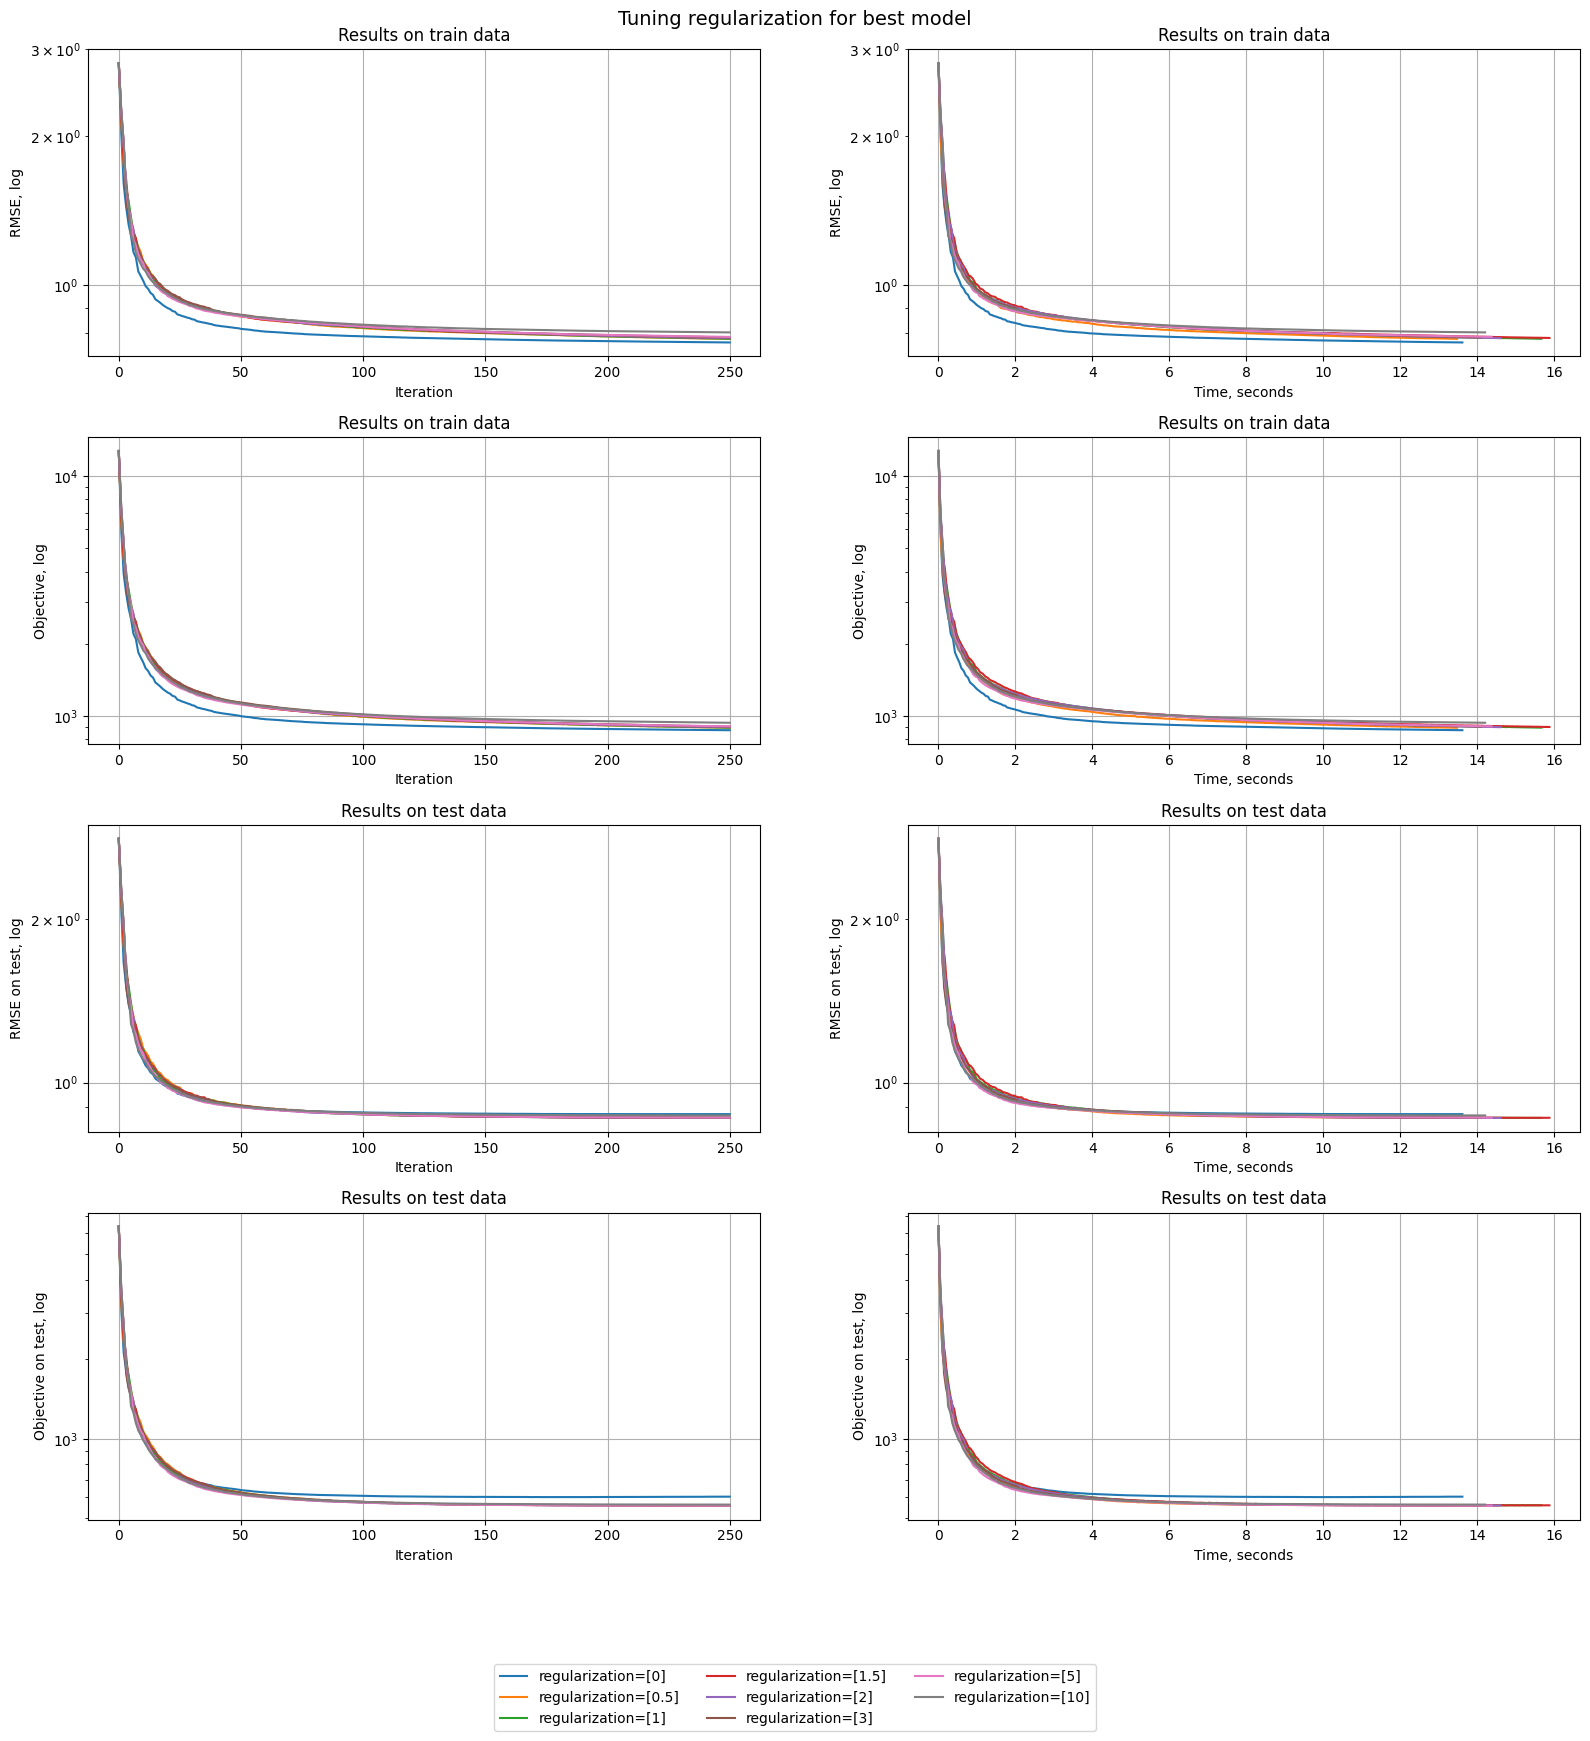

(tensor([[5.0000, 3.5228, 3.1691,  ..., 3.3832, 3.3567, 3.8251],
         [4.2191, 3.2943, 3.1852,  ..., 3.4176, 3.1986, 3.8644],
         [4.1847, 3.3294, 3.3677,  ..., 3.3630, 3.1973, 3.8270],
         ...,
         [3.7256, 2.8034, 2.7102,  ..., 3.1559, 3.3183, 3.7315],
         [4.0979, 2.9552, 2.6026,  ..., 3.2834, 3.5472, 3.7051],
         [3.0000, 1.5901, 1.0000,  ..., 3.0206, 3.9328, 3.4058]],
        device='cuda:0'),
 0.8608934283256531,
 250,
 14.605645179748535,
 'regularization=[2]')

In [30]:
best_gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 250,
        "init_strategy": "svd",
        "optimizer": GradientDescent(lr_scheduler=Estimate1OverL()),
        "regularization": [0, 0.5, 1, 1.5, 2, 3, 5, 10],
        "verbose": True,
    },
)

plot_log_dicts(best_gd_res[-1], "Tuning regularization for best model")

best_gd_res[:-1]

Thus we come to the best setup according to our experiments - Gradient Descent with 1/L lr strategy and regularization factor 2 and rank 10. Let's train it for 1000 iterations and check the results.


100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s, Objective=828, RMSE=0.746, Objective[test]=583, RMSE[test]=0.87]    


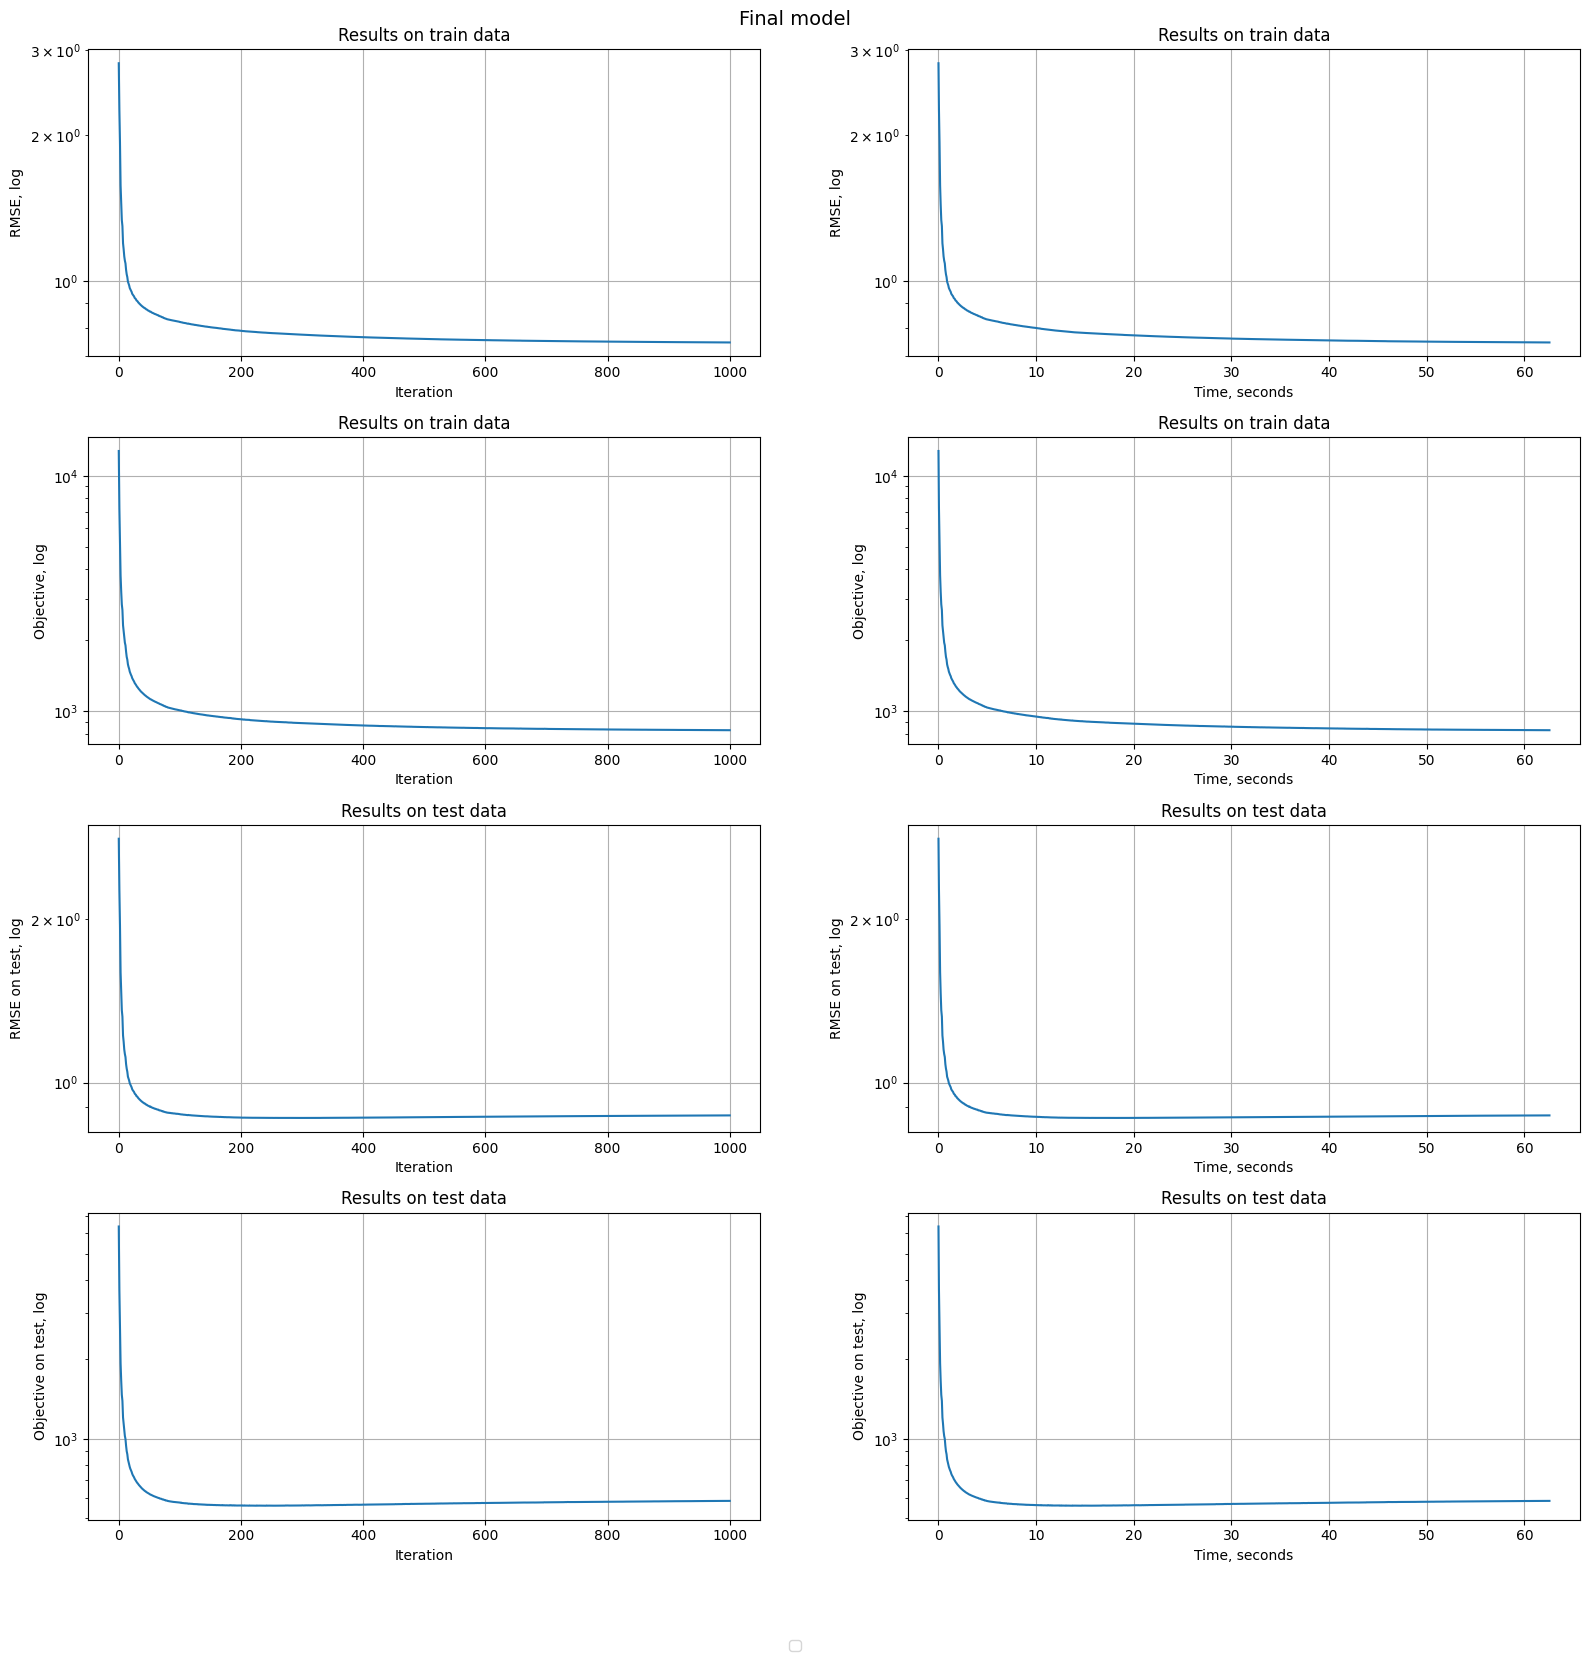

(tensor([[5.0000, 3.5125, 3.1738,  ..., 3.4244, 3.3888, 3.8319],
         [4.2329, 3.3094, 3.2280,  ..., 3.4621, 3.2054, 3.8716],
         [4.1696, 3.3245, 3.3956,  ..., 3.3979, 3.2273, 3.8326],
         ...,
         [3.7124, 2.8085, 2.7204,  ..., 3.1903, 3.3860, 3.7794],
         [4.0919, 2.9491, 2.6022,  ..., 3.3111, 3.5973, 3.7430],
         [3.0000, 1.5749, 1.0000,  ..., 2.9988, 3.9631, 3.4406]],
        device='cuda:0'),
 0.860700249671936,
 283,
 17.41630530357361,
 '')

In [31]:
final_best_gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    pure_gd,
    {
        "rank": 10,
        "iterations": 1000,
        "init_strategy": "svd",
        "optimizer": GradientDescent(lr_scheduler=Estimate1OverL()),
        "regularization": 2,
        "verbose": True,
    },
)

plot_log_dicts(final_best_gd_res[-1], "Final model")

final_best_gd_res[:-1]

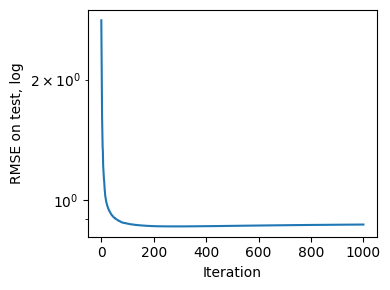

In [127]:
plot_log_dicts_test(final_best_gd_res[-1], "Final model", False)

Let's save achived matrix.


In [32]:
save_solution(final_best_gd_res[0], decimals=5, prefix="final_gd_")

## Vector descent


In [33]:
def vector_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Optimizer,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    verbose: bool = True,
    seed: int = 420,
    device: torch.device = DEVICE,
) -> dict:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    matrix = matrix.to(device)
    mask = mask.to(device)
    test_mask = test_mask.to(device)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy, device=device)
    optimizer.reset()
    optimizer.lr_scheduler.set_assume_vectors(True)  # Important!
    u_optim = optimizer
    v_optim = copy.deepcopy(optimizer)

    # Initial log
    logger = Logger(
        matrix,
        mask,
        test_mask,
        objective_gd,
        f_params={"regularization": 0},
        verbose=verbose,
    )
    logger.log(u, v, 0)

    with tqdm.tqdm(range(1, iterations + 1), disable=not verbose) as loop:
        for k in loop:
            # Optimize

            # u,u,u,v,v
            for idx in range(matrix.shape[0] + matrix.shape[1]):
                residual = idx % 5
                if residual < 3:
                    # Optimize u
                    i = 3 * (idx // 5) + residual
                    if i >= matrix.shape[0]:
                        continue
                    u[i, :] = u_optim.step(
                        u[i, :],
                        lambda x: objective_gd(
                            matrix[i, :],
                            mask[i, :],
                            x,
                            v,
                            regularization=regularization,
                        ),
                        lambda x: nabla_objective_gd(
                            matrix[i, :],
                            mask[i, :],
                            x,
                            v,
                            regularization=regularization,
                        ),
                        k,
                    )

                    if clip:
                        u = torch.clip(u, 0)

                    continue

                # Optimize v
                j = 2 * (idx // 5) + residual - 3
                if j >= matrix.shape[1]:
                    continue
                v[:, j] = v_optim.step(
                    v[:, j],
                    lambda x: objective_gd(
                        matrix[:, j],
                        mask[:, j],
                        u,
                        x,
                        regularization=regularization,
                    ),
                    lambda x: nabla_objective_gd(
                        matrix[:, j],
                        mask[:, j],
                        u,
                        x,
                        regularization=regularization,
                        for_v=True,
                    ),
                    k,
                )

                if clip:
                    v = torch.clip(v, 0)

            # log
            logger.log(u, v, k, loop=loop)

        return logger.log_dict

100%|██████████| 10/10 [00:00<00:00, 627.09it/s, Objective=5.27, RMSE=0.792, Objective[test]=9.39, RMSE[test]=1.75]


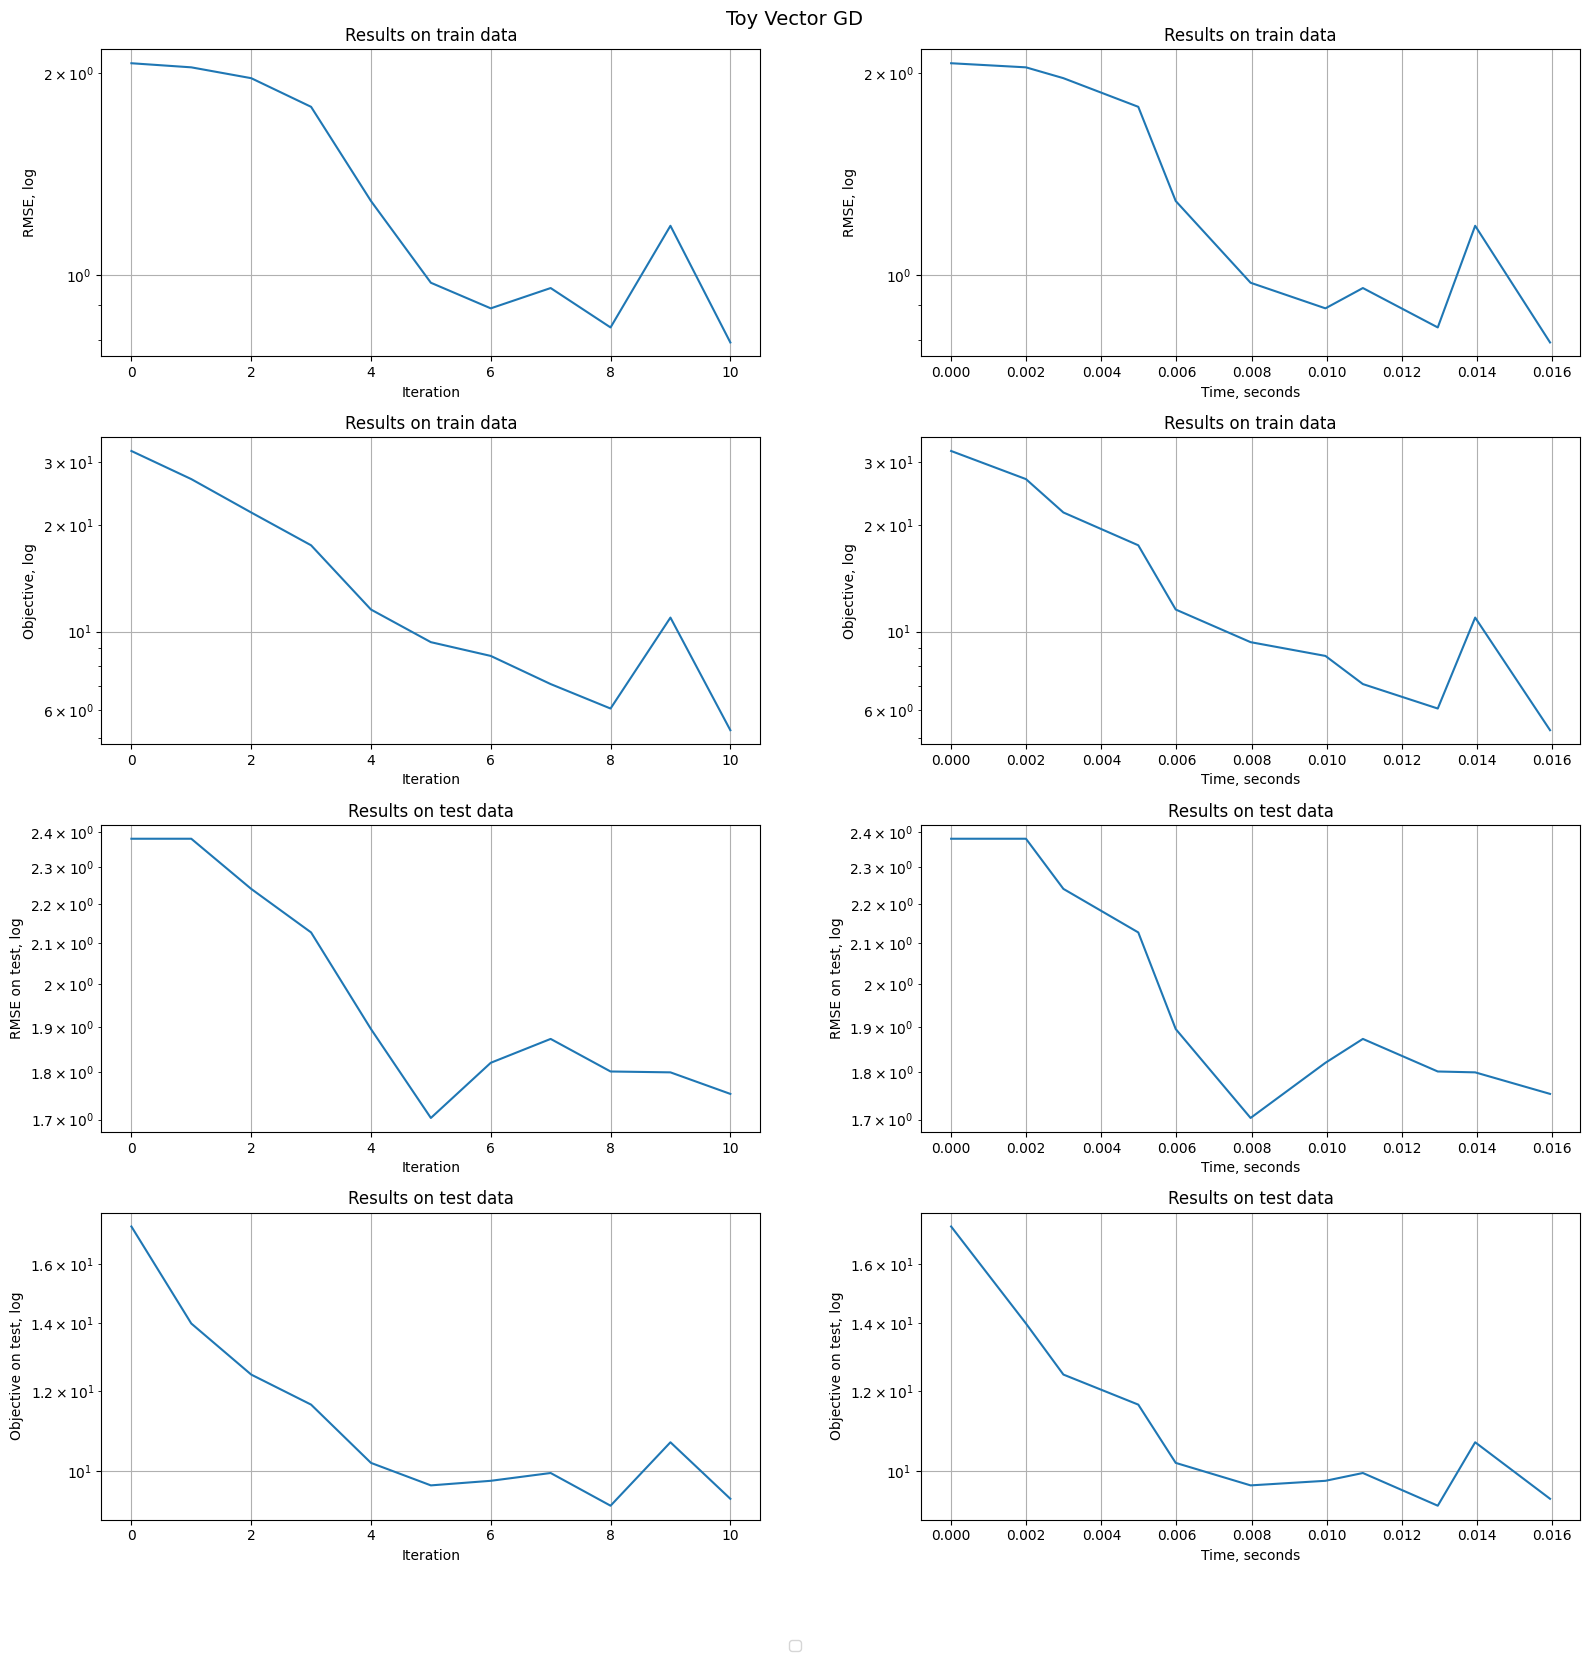

(tensor([[2.0000, 3.0000, 2.0000, 2.7562, 1.0000],
         [1.0000, 2.0000, 2.0342, 4.0000, 4.0000],
         [3.0000, 2.0329, 3.0000, 1.7600, 4.0000],
         [1.1937, 3.0000, 3.0690, 4.0000, 4.0000],
         [1.0000, 1.3317, 1.2757, 1.6912, 2.0000],
         [1.0000, 7.1617, 3.0000, 4.0000, 1.0000]], device='cuda:0'),
 1.7032089233398438,
 5,
 0.007973194122314453,
 '')

In [34]:
vector_gd_toy_res = choose_best(
    toy_matrix_full,
    toy_mask,
    toy_test_mask,
    vector_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "svd",
        "optimizer": GradientDescent(AdaptiveStep()),
        "regularization": 0.1,
        "verbose": True,
        "device": "cpu",
    },
)

plot_log_dicts(vector_gd_toy_res[-1], "Toy Vector GD")

vector_gd_toy_res[:-1]

100%|██████████| 10/10 [02:28<00:00, 14.87s/it, Objective=2.73e+4, RMSE=1.08, Objective[test]=1.29e+4, RMSE[test]=1.14]


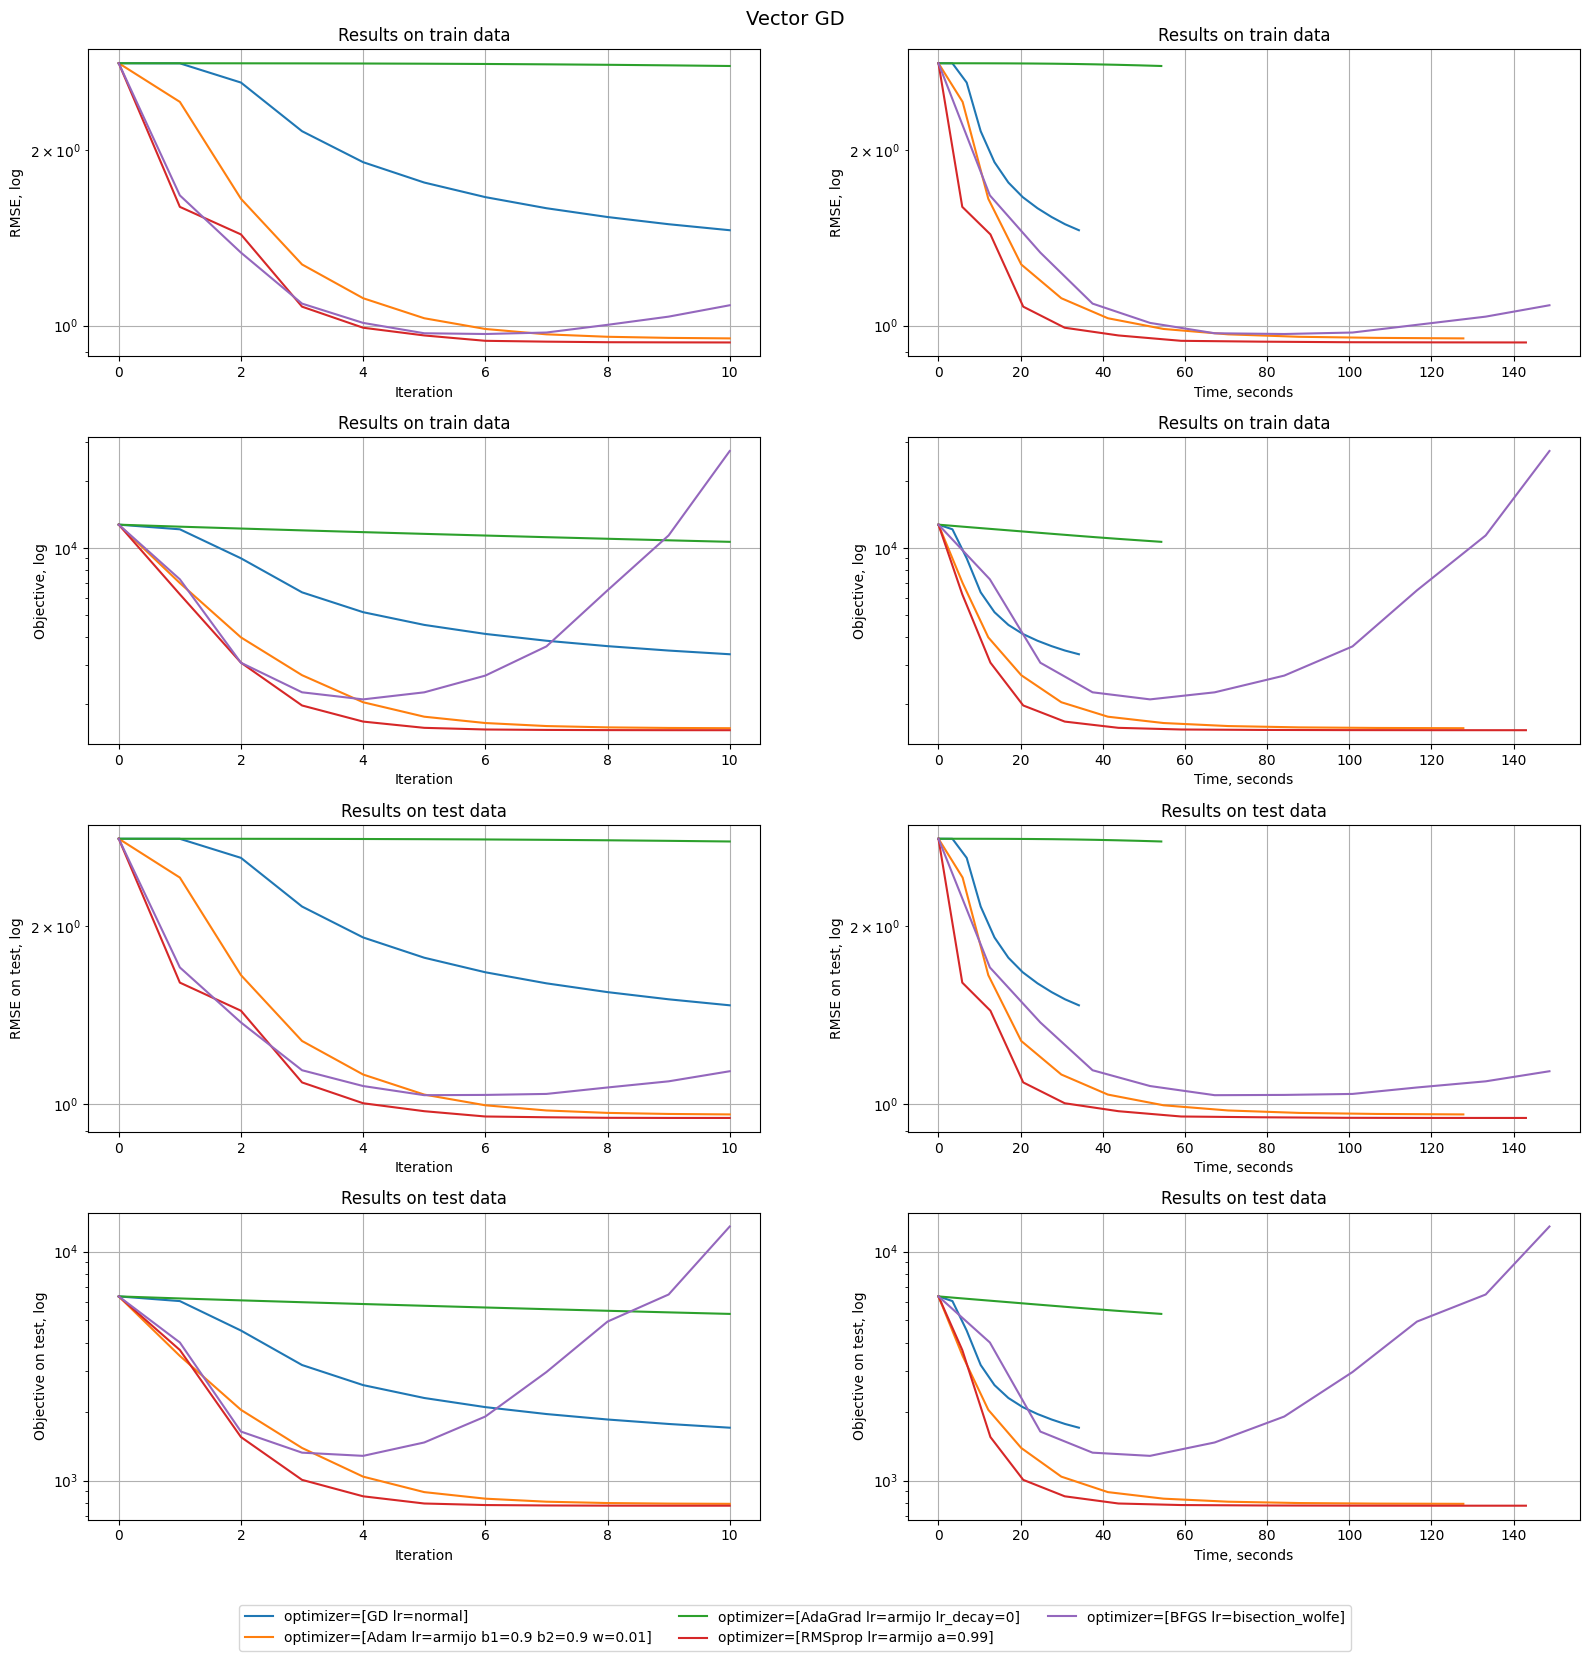

(tensor([[5.0000, 3.2292, 2.3208,  ..., 3.6760, 4.0659, 3.7111],
         [4.1378, 3.0637, 2.4745,  ..., 3.5162, 3.8553, 3.5633],
         [4.1950, 3.0356, 2.2943,  ..., 3.5094, 3.8542, 3.5548],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [3.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 0.9480758905410767,
 10,
 142.99148535728455,
 'optimizer=[RMSprop lr=armijo a=0.99]')

In [ ]:
vector_gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    vector_gd,
    {
        "rank": 10,
        "iterations": 10,
        "init_strategy": "svd",
        "optimizer": [
            GradientDescent(lr_scheduler=Normal(lambda k: 1e-3 / k)),
            Adam(lr_scheduler=Armijo()),
            AdaGrad(lr_scheduler=Armijo()),
            RMSprop(lr_scheduler=Armijo()),
            BFGS(lr_scheduler=BisectionWolfe()),
        ],
        "regularization": 0.5,
        "clip": True,
        "verbose": True,
        "device": "cpu",
    },
)

plot_log_dicts(vector_gd_res[-1], "Vector GD")

vector_gd_res[:-1]

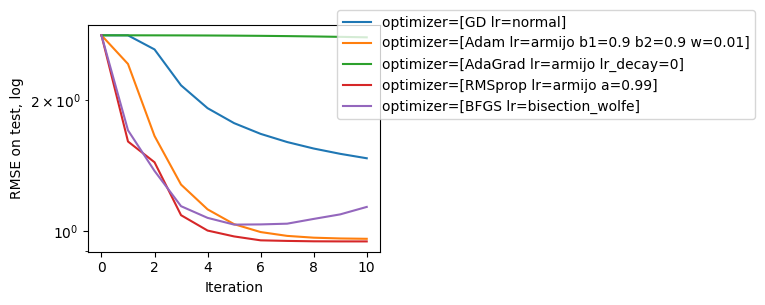

In [128]:
plot_log_dicts_test(vector_gd_res[-1], "Vector GD")

Vector descent is much slower and have higher error than GD methods tested before. Thus it's not very good approach to solve our problem.


## Non-negative Matrix Factorization


We want to solve our initial problem, but with additional non-negativity constraints:
$$ \min\_{U \in \R^{m*r}, V \in \R^{r*n}} \|W \circ (X - UV)\|^2_F$$
s.t. $U, V \geq 0$

Firstly let's recall gradient update from the previous parts:

$$ U \gets U + \alpha_u ((W \circ X) V^T - (W \circ (UV)) V^T) $$

If we'll use $\alpha_u = \cfrac{U}{((W \circ (UV)) V^T)}$, then we'll get:

$$ U \gets U + \alpha_u ((W \circ X) V^T - (W \circ (UV)) V^T) = U + U \circ \cfrac{((W \circ X) V^T)}{((W \circ (UV)) V^T)} - U \circ \cfrac{((W \circ (UV)) V^T)}{((W \circ (UV)) V^T)} = U + U \circ \cfrac{((W \circ X) V^T)}{((W \circ (UV)) V^T)} - U = U \circ \cfrac{((W \circ X) V^T)}{((W \circ (UV)) V^T)} $$

Thus we have achieved multiplicative update for $U$. Now, let's do the same for $V$:

$$ V \gets V + \alpha_v (U^T (W \circ X) - U^T (W \circ (UV))) $$

If we'll use $\alpha_v = \cfrac{V}{(U^T (W \circ (UV)))}$, then we'll get:

$$ V \gets V + \alpha_v (U^T (W \circ X) - U^T (W \circ (UV))) = V + V \circ \cfrac{(U^T (W \circ X))}{(U^T (W \circ (UV)))} - V \circ \cfrac{(U^T (W \circ (UV)))}{(U^T (W \circ (UV)))} = V + V \circ \cfrac{(U^T (W \circ X))}{(U^T (W \circ (UV)))} - V = V \circ \cfrac{(U^T (W \circ X))}{(U^T (W \circ (UV)))}$$

Thus we have achieved multiplicative update for $V$.

Such idea was used in [Lee and Seung paper](https://proceedings.neurips.cc/paper_files/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf) for "unmasked" problem in order to avoid to avoid subtraction and thus the production of negative elements. [Lee and Seung paper](https://proceedings.neurips.cc/paper_files/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf) provided the proof of convergence for such adaptive lerning rates for "unmasked" problem.

However out mask brings some problems with division operation (we might devide on very small/almost zero value, which is very dangerous). Thus we decided to add some small constant $\epsilon$ to denominator to avoid it. This brings our multiplicative updates to be in the following forms:

$$ U \gets U \circ \cfrac{((W \circ X) V^T)}{((W \circ (UV)) V^T + \epsilon)} $$
$$ V \gets V \circ \cfrac{(U^T (W \circ X))}{(U^T (W \circ (UV)) + \epsilon)}$$


In [ ]:
def nnmf(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    init_strategy: Literal["random", "svd"] = "svd",
    verbose: bool = True,
    seed: int = 420,
    device: torch.device = DEVICE,
) -> dict:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy, device=device)
    u = torch.clip(u, 0)
    v = torch.clip(v, 0)

    # Initial log
    logger = Logger(
        matrix,
        mask,
        test_mask,
        objective_gd,
        f_params={"regularization": 0},
        verbose=verbose,
    )
    logger.log(u, v, 0)

    eps = 1e-12
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            # u update
            u = u * (((mask * matrix) @ v.T) / ((mask * (u @ v)) @ v.T + eps))
            # u = torch.max(torch.zeros(u.shape).float().to(DEVICE) + eps, u)

            # v update
            v = v * ((u.T @ (mask * matrix)) / (u.T @ (mask * (u @ v)) + eps))
            # v = torch.max(torch.zeros(v.shape).float().to(DEVICE) + eps, v)

            # log
            logger.log(u, v, k, loop=loop)

    return logger.log_dict

100%|██████████| 30/30 [00:00<00:00, 367.08it/s, Objective=0.147, RMSE=0.131, Objective[test]=5.84, RMSE[test]=1.77]


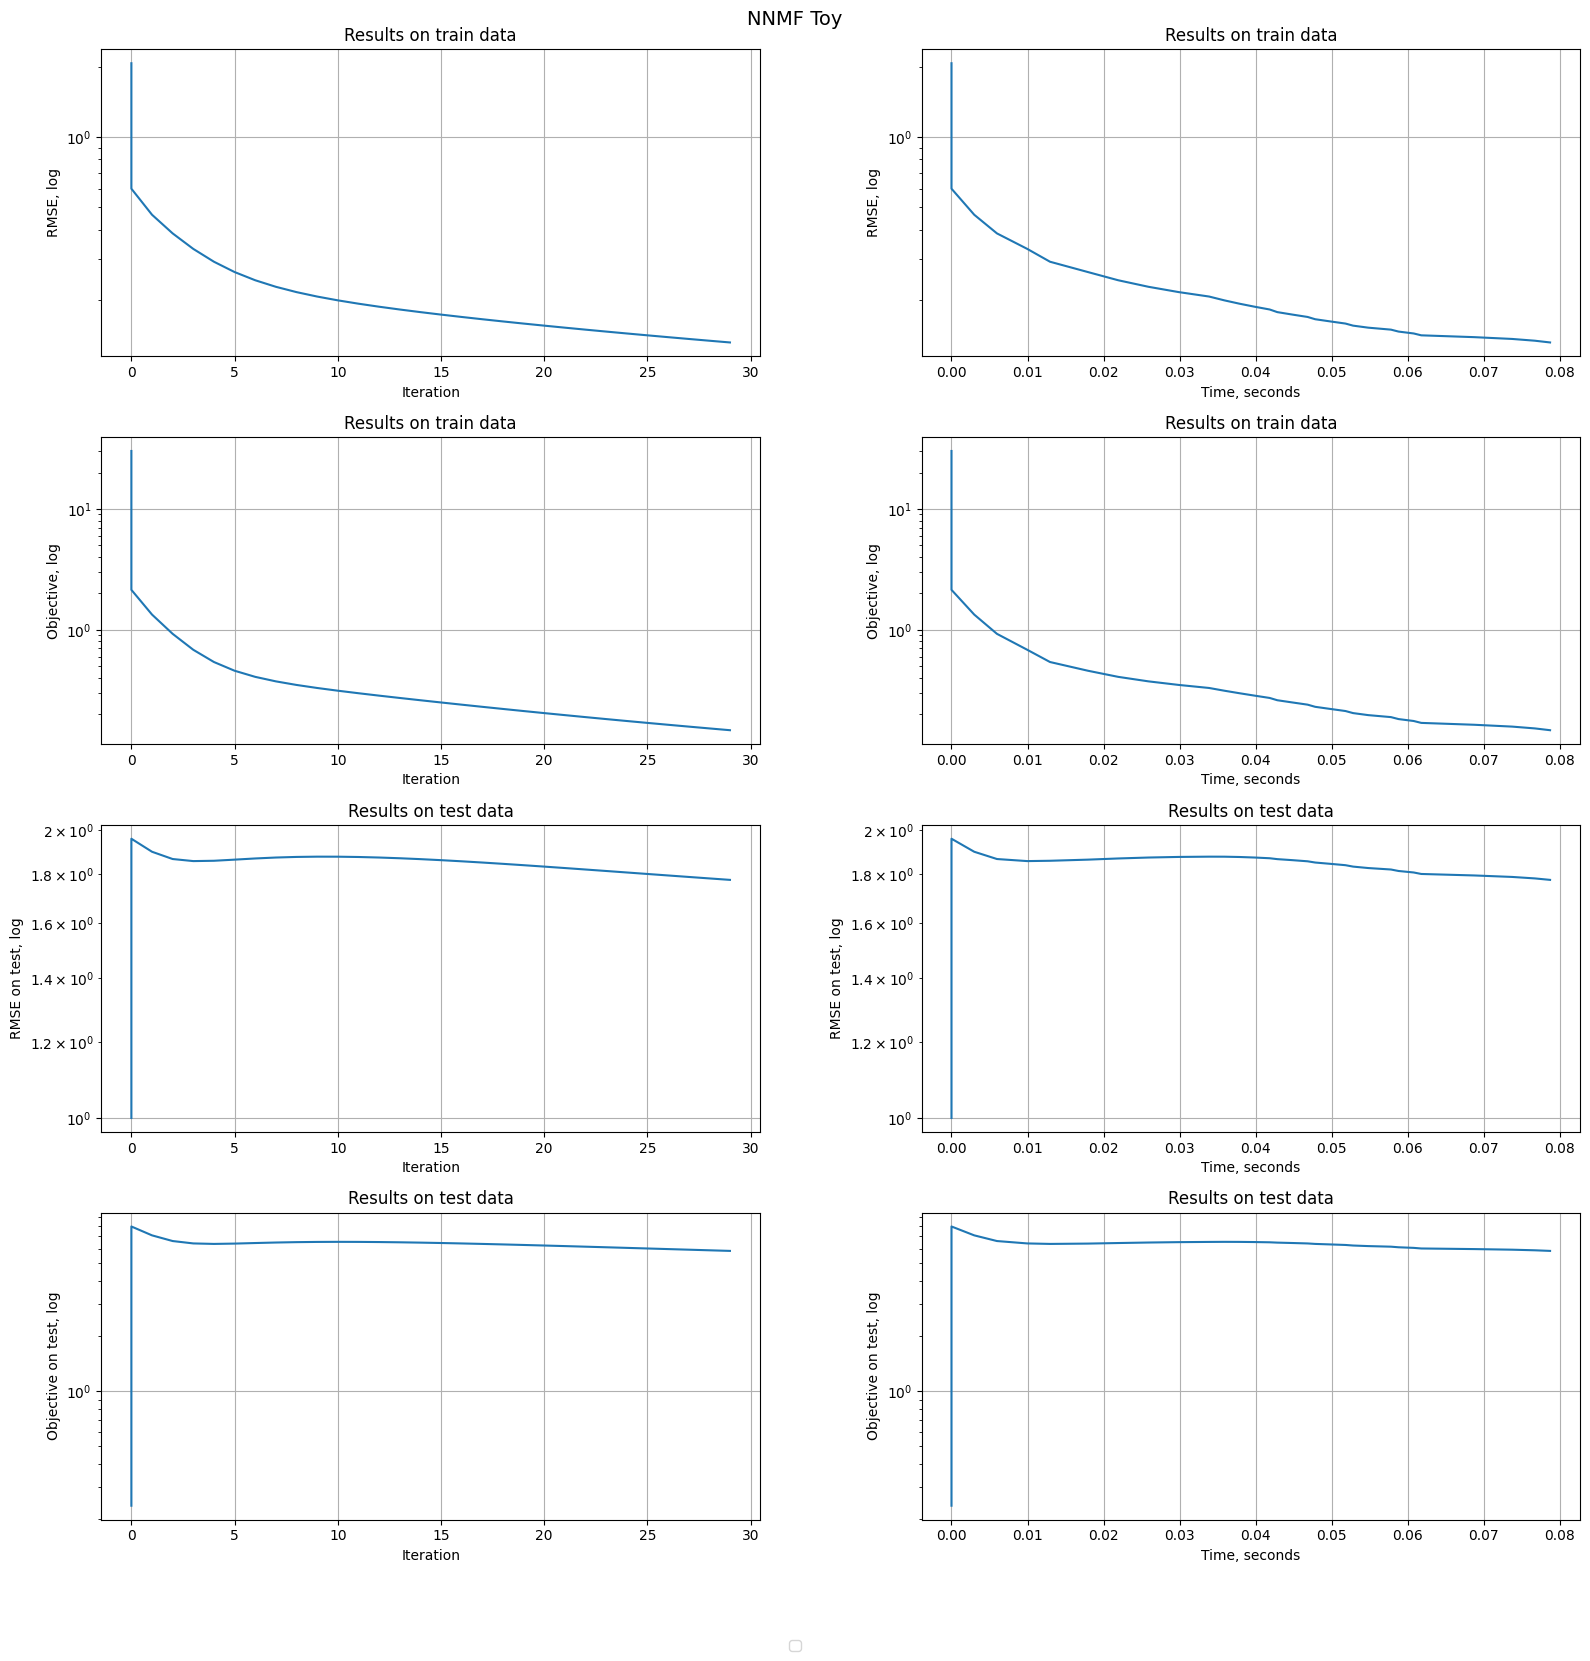

(tensor([[2., 3., 2., 1., 1.],
         [1., 2., 1., 4., 1.],
         [3., 1., 3., 1., 4.],
         [1., 3., 1., 4., 1.],
         [1., 1., 1., 1., 2.],
         [1., 1., 3., 4., 1.]], device='cuda:0'),
 1.0,
 0,
 0,
 '')

In [37]:
nnmf_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    nnmf,
    {
        "rank": 10,
        "iterations": 30,
        "init_strategy": "svd",
        "verbose": True,
    },
)

plot_log_dicts(nnmf_toy_res[-1], "NNMF Toy")

nnmf_toy_res[:-1]

100%|██████████| 30/30 [00:00<00:00, 96.50it/s, Objective=812, RMSE=0.739, Objective[test]=5.93e+3, RMSE[test]=3.66]


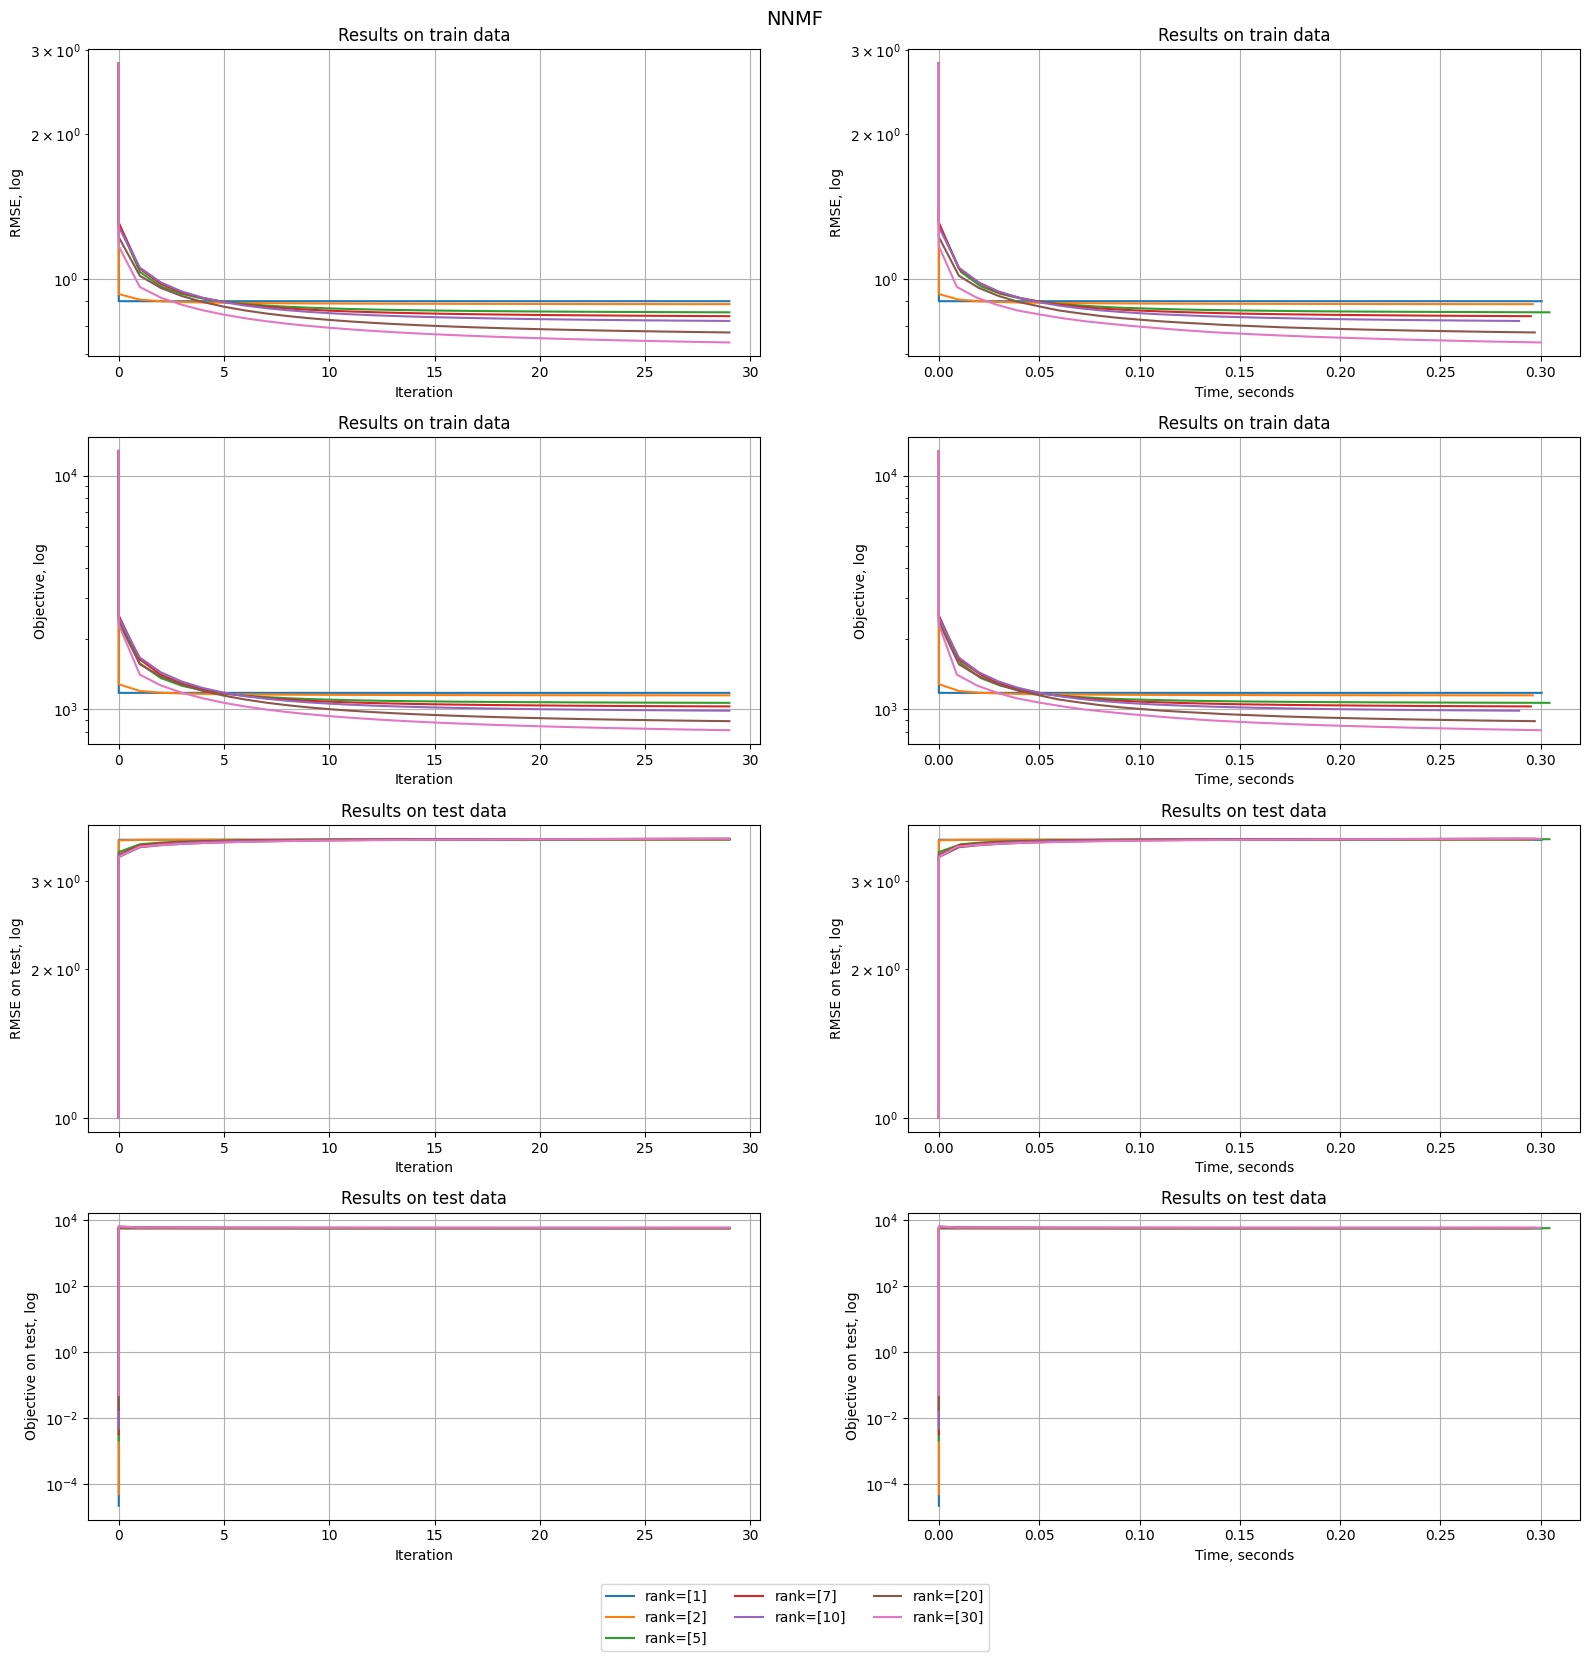

(tensor([[5., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'),
 1.0,
 0,
 0,
 'rank=[1]')

In [38]:
nnmf_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    nnmf,
    {
        "rank": [1, 2, 5, 7, 10, 20, 30],
        "iterations": 30,
        "init_strategy": "svd",
        "verbose": True,
    },
)

plot_log_dicts(nnmf_res[-1], "NNMF")

nnmf_res[:-1]

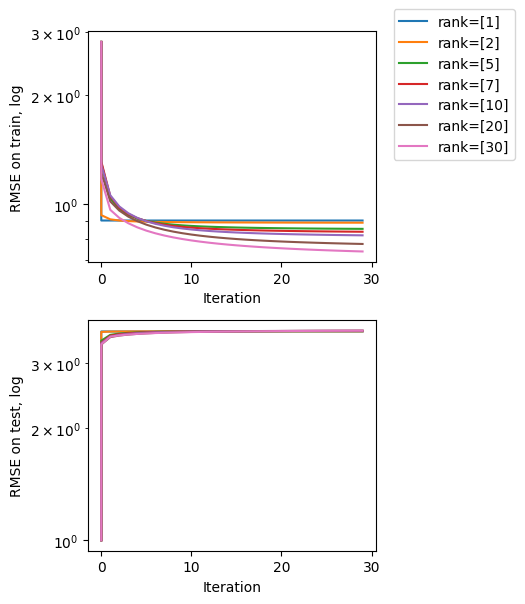

In [143]:
plot_double_log_dicts_test(nnmf_res[-1], "NNMF")

As we can see NNMF completely fails our expectations. It decreases training error, but on test data it makes everything even worse.


## Neural Networks


As an alternative approach we decided to train simple neural network with such parameters:

- 4 layers (23\*64, 64\*128, 128\*64, 64\*1)
- ReLU as activation function after each layer
- MSELoss criterion
- Adam optimizer with `lr=1e-3`
- Early stopping (if on test set loss is not decreasing for 3 iterations)
- Maximum number of training epochs = 50

As input to our model we decided to use:

- Minmax scaled `user_id`
- Minmax scaled `movie_id`
- One-hot encoded `genres` (we have 18 unique genres)
- Binary encoded `gender`
- Minmax scaled first two user features (`feature_1` and `feature_2`)

In output we have just one number - rating for specific pair of user and film.


### Prepare data


In [ ]:
data = pd.read_csv(
    "./data/Data/csv/ratings_given.csv",
    sep=",",
    header=None,
    names=["user_id", "movie_id", "rating"],
)
data

user_id  movie_id  rating
0             1      1193       5
1             1       661       3
2             1       914       3
3             1      3408       4
4             1      2355       5
...         ...       ...     ...
800163     6040      1090       3
800164     6040      1091       1
800165     6040      1094       5
800166     6040       562       5
800167     6040      1096       4

[800168 rows x 3 columns]

In [ ]:
movies = pd.read_csv(
    "./data/Data/movies.dat",
    sep="::",
    header=None,
    names=["movie_id", "name", "genres"],
    encoding="ISO-8859-1",
)
movies

movie_id                                name  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                            genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880                         Drama  
3881                         Drama  
3882                Drama|Thriller  

[3883 rows x 3 columns]

Let's encode genres in a more usefull for NN way:


In [ ]:
genres = set()
for index, row in movies.iterrows():
    genres.update(row["genres"].split("|"))

genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [ ]:
for genre in genres:
    movies[genre] = movies["genres"].apply(lambda x: 1 if genre in x.split("|") else 0)

movies

movie_id                                name  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                            genres  Comedy  Adventure  Mystery  Western  \
0      Animation|Children's|Comedy       1          0        0        0   
1     Adventure|Children's|Fantasy       0          1        0        0   
2                   Comedy|Romance       1          0        0        0   
3                     Comedy|Drama       1          0        0        0   
4                           Comedy       1          0        0        0   
...                            ...     ...        ...      ...      ...   
3878                        Comedy       1          0        0        0   
3879                         Drama       0          0        0        0   
3880                         Drama       0          0        0        0   
3881                         Drama       0          0        0        0   
3882                Drama|Thriller       0          0        0        0   

      Musical  Thriller  Drama  ...  Crime  Children's  Fantasy  Action  \
0           0         0      0  ...      0           1        0       0   
1           0         0      0  ...      0           1        1       0   
2           0         0      0  ...      0           0        0       0   
3           0         0      1  ...      0           0        0       0   
4           0         0      0  ...      0           0        0       0   
...       ...       ...    ...  ...    ...         ...      ...     ...   
3878        0         0      0  ...      0           0        0       0   
3879        0         0      1  ...      0           0        0       0   
3880        0         0      1  ...      0           0        0       0   
3881        0         0      1  ...      0           0        0       0   
3882        0         1      1  ...      0           0        0       0   

      Romance  Horror  Sci-Fi  Documentary  Film-Noir  Animation  
0           0       0       0            0          0          1  
1           0       0       0            0          0          0  
2           1       0       0            0          0          0  
3           0       0       0            0          0          0  
4           0       0       0            0          0          0  
...       ...     ...     ...          ...        ...        ...  
3878        0       0       0            0          0          0  
3879        0       0       0            0          0          0  
3880        0       0       0            0          0          0  
3881        0       0       0            0          0          0  
3882        0       0       0            0          0          0  

[3883 rows x 21 columns]

In [ ]:
movies = movies.drop("genres", axis=1)
movies

movie_id                                name  Comedy  Adventure  \
0            1                    Toy Story (1995)       1          0   
1            2                      Jumanji (1995)       0          1   
2            3             Grumpier Old Men (1995)       1          0   
3            4            Waiting to Exhale (1995)       1          0   
4            5  Father of the Bride Part II (1995)       1          0   
...        ...                                 ...     ...        ...   
3878      3948             Meet the Parents (2000)       1          0   
3879      3949          Requiem for a Dream (2000)       0          0   
3880      3950                    Tigerland (2000)       0          0   
3881      3951             Two Family House (2000)       0          0   
3882      3952               Contender, The (2000)       0          0   

      Mystery  Western  Musical  Thriller  Drama  War  Crime  Children's  \
0           0        0        0         0      0    0      0           1   
1           0        0        0         0      0    0      0           1   
2           0        0        0         0      0    0      0           0   
3           0        0        0         0      1    0      0           0   
4           0        0        0         0      0    0      0           0   
...       ...      ...      ...       ...    ...  ...    ...         ...   
3878        0        0        0         0      0    0      0           0   
3879        0        0        0         0      1    0      0           0   
3880        0        0        0         0      1    0      0           0   
3881        0        0        0         0      1    0      0           0   
3882        0        0        0         1      1    0      0           0   

      Fantasy  Action  Romance  Horror  Sci-Fi  Documentary  Film-Noir  \
0           0       0        0       0       0            0          0   
1           1       0        0       0       0            0          0   
2           0       0        1       0       0            0          0   
3           0       0        0       0       0            0          0   
4           0       0        0       0       0            0          0   
...       ...     ...      ...     ...     ...          ...        ...   
3878        0       0        0       0       0            0          0   
3879        0       0        0       0       0            0          0   
3880        0       0        0       0       0            0          0   
3881        0       0        0       0       0            0          0   
3882        0       0        0       0       0            0          0   

      Animation  
0             1  
1             0  
2             0  
3             0  
4             0  
...         ...  
3878          0  
3879          0  
3880          0  
3881          0  
3882          0  

[3883 rows x 20 columns]

In [ ]:
users = pd.read_csv(
    "./data/Data/users.dat",
    sep="::",
    header=None,
    names=["user_id", "gender", "feature_1", "feature_2", "feature_3"],
    encoding="ISO-8859-1",
)
users

user_id gender  feature_1  feature_2 feature_3
0           1      F          1         10     48067
1           2      M         56         16     70072
2           3      M         25         15     55117
3           4      M         45          7     02460
4           5      M         25         20     55455
...       ...    ...        ...        ...       ...
6035     6036      F         25         15     32603
6036     6037      F         45          1     76006
6037     6038      F         56          1     14706
6038     6039      F         45          0     01060
6039     6040      M         25          6     11106

[6040 rows x 5 columns]

In [ ]:
def users_encode(users):
    users_enc = users.copy()
    users_enc["feature_1"] = users["feature_1"] / users_enc["feature_1"].max()
    users_enc["feature_2"] = users["feature_2"] / users_enc["feature_2"].max()
    users_enc["gender"] = (users["gender"] == "M").astype(int)
    return users_enc


def build_dataset(data, users, movies):
    ud = pd.merge(data, users, on="user_id", how="outer")
    udm = pd.merge(ud, movies, on="movie_id", how="inner")
    udm_f = users_encode(udm)
    max_user_id = udm_f["user_id"].max()
    max_movie_id = udm_f["movie_id"].max()
    udm_f["user_id"] = udm_f["user_id"] / max_user_id
    udm_f["movie_id"] = udm_f["movie_id"] / max_movie_id
    udm_f = udm_f.drop("name", axis=1)
    udm_f = udm_f.drop("feature_3", axis=1)
    return udm_f


dataset = build_dataset(data, users, movies)
dataset

user_id  movie_id  rating  gender  feature_1  feature_2  Comedy  \
0       0.000166  0.301872       5       0   0.017857        0.5       0   
1       0.000166  0.167257       3       0   0.017857        0.5       0   
2       0.000166  0.231275       3       0   0.017857        0.5       0   
3       0.000166  0.862348       4       0   0.017857        0.5       0   
4       0.000166  0.595901       5       0   0.017857        0.5       1   
...          ...       ...     ...     ...        ...        ...     ...   
800163  1.000000  0.275810       3       1   0.446429        0.3       0   
800164  1.000000  0.276063       1       1   0.446429        0.3       1   
800165  1.000000  0.276822       5       1   0.446429        0.3       0   
800166  1.000000  0.142206       5       1   0.446429        0.3       1   
800167  1.000000  0.277328       4       1   0.446429        0.3       0   

        Adventure  Mystery  Western  ...  Crime  Children's  Fantasy  Action  \
0               0        0        0  ...      0           0        0       0   
1               0        0        0  ...      0           1        0       0   
2               0        0        0  ...      0           0        0       0   
3               0        0        0  ...      0           0        0       0   
4               0        0        0  ...      0           1        0       0   
...           ...      ...      ...  ...    ...         ...      ...     ...   
800163          0        0        0  ...      0           0        0       0   
800164          0        0        0  ...      0           0        0       0   
800165          0        0        0  ...      0           0        0       0   
800166          0        0        0  ...      0           0        0       0   
800167          0        0        0  ...      0           0        0       0   

        Romance  Horror  Sci-Fi  Documentary  Film-Noir  Animation  
0             0       0       0            0          0          0  
1             0       0       0            0          0          1  
2             1       0       0            0          0          0  
3             0       0       0            0          0          0  
4             0       0       0            0          0          1  
...         ...     ...     ...          ...        ...        ...  
800163        0       0       0            0          0          0  
800164        0       0       0            0          0          0  
800165        1       0       0            0          0          0  
800166        0       0       0            0          0          0  
800167        0       0       0            0          0          0  

[800168 rows x 24 columns]

In [ ]:
def separate_and_split_data(data, target_c):
    new_df = data.copy()
    X = new_df.iloc[:, new_df.columns != target_c]
    Y = new_df[target_c]
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.01, random_state=0
    )
    return X_train, X_test, Y_train, Y_test


x_train, x_test, y_train, y_test = separate_and_split_data(dataset, "rating")
x_train

user_id  movie_id  gender  feature_1  feature_2  Comedy  Adventure  \
427372  0.546026  0.723178       1   0.017857       0.50       1          0   
475517  0.599007  0.096660       1   1.000000       0.85       0          0   
275541  0.334603  0.339575       1   0.446429       0.00       0          0   
598534  0.739404  0.352733       1   0.625000       0.55       1          0   
51651   0.071358  0.400810       1   0.321429       0.50       0          0   
...          ...       ...     ...        ...        ...     ...        ...   
359783  0.459106  0.240132       1   0.625000       0.10       0          0   
152315  0.195530  0.405617       1   0.625000       0.35       0          0   
117952  0.157119  0.593117       1   0.892857       0.85       0          1   
435829  0.555960  0.267966       0   0.446429       0.05       0          0   
305711  0.369536  0.092105       1   0.446429       0.70       0          0   

        Mystery  Western  Musical  ...  Crime  Children's  Fantasy  Action  \
427372        0        0        0  ...      0           0        0       0   
475517        0        0        0  ...      0           0        0       0   
275541        0        0        0  ...      0           0        0       0   
598534        0        0        0  ...      0           0        0       0   
51651         0        0        0  ...      0           0        0       0   
...         ...      ...      ...  ...    ...         ...      ...     ...   
359783        0        0        0  ...      0           0        0       0   
152315        0        0        0  ...      0           0        0       0   
117952        0        0        0  ...      0           0        0       1   
435829        0        0        0  ...      0           0        0       0   
305711        0        0        1  ...      0           1        0       0   

        Romance  Horror  Sci-Fi  Documentary  Film-Noir  Animation  
427372        0       0       0            0          0          0  
475517        0       1       0            0          0          0  
275541        0       1       0            0          0          0  
598534        0       0       0            0          0          0  
51651         0       0       1            0          0          0  
...         ...     ...     ...          ...        ...        ...  
359783        0       0       0            0          0          0  
152315        0       0       1            0          0          0  
117952        0       0       0            0          0          0  
435829        1       0       0            0          0          0  
305711        0       0       0            0          0          1  

[792166 rows x 23 columns]

In [47]:
train_batch_size = 1024
test_batch_size = 512


train_target = torch.tensor(y_train.values.astype(np.float32))
train_features = torch.tensor(x_train.values.astype(np.float32))

test_target = torch.tensor(y_test.values.astype(np.float32))
test_features = torch.tensor(x_test.values.astype(np.float32))

train_dataset = data_utils.TensorDataset(train_features, train_target)
test_dataset = data_utils.TensorDataset(test_features, test_target)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

### Train model


In [58]:
torch.cuda.empty_cache()

In [ ]:
class RecSys(nn.Module):
    def __init__(self):
        super(RecSys, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(23, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.head = nn.Linear(64, 1)

    def forward(self, x):
        deep_logits = self.linear_relu_stack(x)
        total_logits = self.head(deep_logits)
        return total_logits


model = RecSys().to(DEVICE)
model

RecSys(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
log_interval = 10


def train(model, device, train_loader, criterion, optimizer, epoch, show_results=True):
    model.train()
    start_time = time.time()
    epoch_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        if show_results:
            if batch_idx % log_interval == 0:
                print(
                    f"\rTrain Epoch {epoch}:",
                    f"[{batch_idx * len(data)}/{len(train_loader.dataset)}",
                    f"({100. * batch_idx / len(train_loader):.0f}%)]",
                    f"\tLoss: {loss.item():.6f}",
                    end="",
                )

    if show_results:
        print(
            f"\rTrain Epoch: {epoch} Average Loss: {epoch_loss/(len(train_loader.dataset)):.6f}, elapsed time:{time.time()-start_time:.2f}s"
        )


def test(model, device, test_loader, criterion, show_results=True):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target).item() * len(target)

    test_loss /= len(test_loader.dataset)

    if show_results:
        print("\rTest set: Average loss: {:.4f}".format(test_loss))
    return test_loss


def evaluate(
    model, epochs=50, criterion=nn.MSELoss(), show_results=True, early_stopping=True
):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    min_test_loss = float("inf")
    min_test_length = 0
    min_test_limit = 3
    min_epoch = -1

    for epoch in range(1, epochs + 1):
        train(model, DEVICE, train_loader, criterion, optimizer, epoch, show_results)
        val = test(model, DEVICE, test_loader, criterion, show_results)
        if val < min_test_loss:
            min_epoch = epoch
            min_test_loss = val
            min_test_length = 0
            torch.save(model, "./models/best_model")
        else:
            min_test_length += 1

        if early_stopping:
            if min_test_length >= min_test_limit or epoch == epochs:
                if show_results:
                    print(
                        "Best model was at epoch ",
                        min_epoch,
                        " with value ",
                        min_test_loss,
                    )
                break
        else:
            if epoch == epochs:
                if show_results:
                    print(
                        "Best model was at epoch ",
                        min_epoch,
                        " with value ",
                        min_test_loss,
                    )

    return min_test_loss

In [61]:
evaluate(model)

Train Epoch: 1 Average Loss: 1.498802, elapsed time:4.89s
Test set: Average loss: 1.1837
Train Epoch: 2 Average Loss: 1.161575, elapsed time:4.80s
Test set: Average loss: 1.1683
Train Epoch: 3 Average Loss: 1.150675, elapsed time:4.92s
Test set: Average loss: 1.1696
Train Epoch: 4 Average Loss: 1.140725, elapsed time:4.87s
Test set: Average loss: 1.1503
Train Epoch: 5 Average Loss: 1.132899, elapsed time:5.60s
Test set: Average loss: 1.1441
Train Epoch: 6 Average Loss: 1.127462, elapsed time:5.54s
Test set: Average loss: 1.1385
Train Epoch: 7 Average Loss: 1.120168, elapsed time:5.56s
Test set: Average loss: 1.1334
Train Epoch: 8 Average Loss: 1.116793, elapsed time:5.46s
Test set: Average loss: 1.1361
Train Epoch: 9 Average Loss: 1.112401, elapsed time:5.48s
Test set: Average loss: 1.1258
Train Epoch: 10 Average Loss: 1.110247, elapsed time:5.61s
Test set: Average loss: 1.1322
Train Epoch: 11 Average Loss: 1.108366, elapsed time:5.54s
Test set: Average loss: 1.1293
Train Epoch: 12 Ave

1.1174457707246581

In [62]:
model = torch.load("./models/best_model").to(DEVICE)

### Predict


In [ ]:
fin_data = pd.read_csv(
    "./data/Data/csv/ratings_test_eval.csv",
    sep=",",
    header=None,
    names=["user_id", "movie_id"],
)
fin_data

user_id  movie_id
1             1       594
2             1      3105
3             1      1545
4             1      2762
5             1      2028
...         ...       ...
200037     6040      3342
200038     6040      2725
200039     6040      2762
200040     6040      2010
200041     6040      2022

[200041 rows x 2 columns]

In [64]:
fin_dataset = build_dataset(fin_data, users, movies)
fin_dataset

user_id  movie_id  gender  feature_1  feature_2  Comedy  Adventure  \
0       0.000166  0.150304       0   0.017857        0.5       0          0   
1       0.000166  0.785678       0   0.017857        0.5       0          0   
2       0.000166  0.390941       0   0.017857        0.5       0          0   
3       0.000166  0.698887       0   0.017857        0.5       0          0   
4       0.000166  0.513158       0   0.017857        0.5       0          0   
...          ...       ...     ...        ...        ...     ...        ...   
200036  1.000000  0.845648       1   0.446429        0.3       0          0   
200037  1.000000  0.689524       1   0.446429        0.3       0          0   
200038  1.000000  0.698887       1   0.446429        0.3       0          0   
200039  1.000000  0.508603       1   0.446429        0.3       0          0   
200040  1.000000  0.511640       1   0.446429        0.3       0          0   

        Mystery  Western  Musical  ...  Crime  Children's  Fantasy  Action  \
0             0        0        1  ...      0           1        0       0   
1             0        0        0  ...      0           0        0       0   
2             0        0        0  ...      0           0        0       0   
3             0        0        0  ...      0           0        0       0   
4             0        0        0  ...      0           0        0       1   
...         ...      ...      ...  ...    ...         ...      ...     ...   
200036        0        0        0  ...      0           0        0       0   
200037        0        0        0  ...      0           0        0       0   
200038        0        0        0  ...      0           0        0       0   
200039        0        0        0  ...      0           0        0       0   
200040        0        0        0  ...      0           0        0       0   

        Romance  Horror  Sci-Fi  Documentary  Film-Noir  Animation  
0             0       0       0            0          0          1  
1             0       0       0            0          0          0  
2             0       0       0            0          0          0  
3             0       0       0            0          0          0  
4             0       0       0            0          0          0  
...         ...     ...     ...          ...        ...        ...  
200036        0       0       0            0          0          0  
200037        0       0       0            0          0          0  
200038        0       0       0            0          0          0  
200039        0       0       1            0          0          0  
200040        0       0       0            0          0          0  

[200041 rows x 23 columns]

In [65]:
final_tensor = torch.tensor(fin_dataset.values.astype(np.float32))
final_dataset = data_utils.TensorDataset(final_tensor)
final_loader = DataLoader(final_dataset, batch_size=test_batch_size, shuffle=False)

In [66]:
def predict(model, device, test_loader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data[0].to(device)
            output = model(data)
            predictions += output.detach().cpu().tolist()
    return predictions

In [67]:
predictions = predict(model, DEVICE, final_loader)
predictions[:10]

[[3.6194045543670654],
 [3.71763277053833],
 [3.9145121574401855],
 [3.406730890274048],
 [4.1477813720703125],
 [4.1262593269348145],
 [3.6292614936828613],
 [4.397319793701172],
 [3.788909912109375],
 [3.6738781929016113]]

In [ ]:
results = pd.DataFrame(columns=["Rating"])
results["Rating"] = pd.Series(predictions).apply(lambda x: x[0])
results

Rating
0       3.619405
1       3.717633
2       3.914512
3       3.406731
4       4.147781
...          ...
200036  3.843665
200037  3.624710
200038  3.811286
200039  3.351877
200040  3.691504

[200041 rows x 1 columns]

In [69]:
results.index = np.arange(1, len(results) + 1)
results

Rating
1       3.619405
2       3.717633
3       3.914512
4       3.406731
5       4.147781
...          ...
200037  3.843665
200038  3.624710
200039  3.811286
200040  3.351877
200041  3.691504

[200041 rows x 1 columns]

In [ ]:
results.to_csv("./solutions/nn_submission.csv", index_label="ID")